**Problem statement:**

A game designer has asked you to help them identify users that are likely to spend money in their game after
finishing the tutorial. They would like to give different prices to new users who are likely to spend money in the
game. A data set has been provided to you with data on individual players and their spending habits since the
launch of the game. You are to provide a solution for the game designer.
We ask that you use Python to complete this assignment, but you are free to use any open source libraries.

In kabam_ds_interview_data.zip you will find:

● 2 data files

● 1 sqlite database

● A data dictionary that describes the data files


###**Solution:**

First, we need to import all libraries and datasets.

In [ ]:
#import all libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns
import pyarrow.parquet as pq
import sqlite3 
import scipy
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from functools import reduce
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format = 'retina'

from google.colab import drive 
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


In [ ]:
#Read devices dataset in pandas dataframe
conn=sqlite3.connect('/content/drive/MyDrive/kabam_ds_interview/kabam_ds_interview/ka_devices.db')
devices=pd.read_sql_query("SELECT * FROM devices",conn)
devices.drop(columns='index',inplace=True)
devices.head()

,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


In [ ]:
#check the list of the columns and their data type
devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845931 entries, 0 to 2845930
Data columns (total 13 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   uid_s                   int64  
 1   platform_s              object 
 2   device_mapped_s         object 
 3   device_manufacturer_s   object 
 4   device_mem_i            float64
 5   device_gmem_i           float64
 6   device_mem_grouping_i   float64
 7   device_gmem_grouping_i  float64
 8   device_numcpu_i         float64
 9   device_height_i         float64
 10  device_gpu_s            object 
 11  device_os_s             object 
 12  device_model_s          object 
dtypes: float64(6), int64(1), object(6)
memory usage: 282.3+ MB


In [ ]:
#Read users dataset in pandas dataframe
users=pd.read_csv('/content/drive/MyDrive/kabam_ds_interview/kabam_ds_interview/ka_users.csv')
users.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0


In [ ]:
#check the list of the columns and their data type
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845931 entries, 0 to 2845930
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   uid_s                 int64 
 1   lang_s                object
 2   geo_s                 object
 3   region_s              object
 4   tz_i                  int64 
 5   local_time_join_hour  int64 
 6   local_time_join_dow   int64 
 7   total_spend           int64 
dtypes: int64(5), object(3)
memory usage: 173.7+ MB


In [ ]:
#Read actions dataset in pandas dataframe
actions = pq.read_table(source='/content/drive/MyDrive/kabam_ds_interview/kabam_ds_interview/ka_actions.parquet').to_pandas()
actions.head()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0


In [ ]:
#check the list of the columns and their data type
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845931 entries, 0 to 2845930
Data columns (total 10 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   uid_s                              int64  
 1   logins                             float64
 2   game_stats_tutorial_complete       float64
 3   game_stats_tutorial_complete_time  float64
 4   game_stats_xp                      float64
 5   game_stats_xp1                     float64
 6   game_stats_xp2                     float64
 7   game_stats_xp3                     float64
 8   redeemer_actions                   float64
 9   scribe_actions                     float64
dtypes: float64(9), int64(1)
memory usage: 217.1 MB


In the following, final dataframe which contains the columns of all datasets is shown. In addition, the data type of the column, statistical information about the column and the number of missing values of the column are shown.

In [ ]:
# Final Dataframe contains all information
dfs=[users,actions,devices]
df_final=reduce(lambda left,right:pd.merge(left,right,on='uid_s'),dfs)
df_final.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,EN,MY,asia,28800,14,3,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,ES,MX,americas,-18000,14,1,0,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,ZH-CN,CN,asia,28800,2,3,0,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,ZH-CN,CN,asia,28800,8,6,0,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,EN,IN,asia,19800,19,6,0,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


In [ ]:
#check the list of the columns and their data type
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845931 entries, 0 to 2845930
Data columns (total 29 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   uid_s                              int64  
 1   lang_s                             object 
 2   geo_s                              object 
 3   region_s                           object 
 4   tz_i                               int64  
 5   local_time_join_hour               int64  
 6   local_time_join_dow                int64  
 7   total_spend                        int64  
 8   logins                             float64
 9   game_stats_tutorial_complete       float64
 10  game_stats_tutorial_complete_time  float64
 11  game_stats_xp                      float64
 12  game_stats_xp1                     float64
 13  game_stats_xp2                     float64
 14  game_stats_xp3                     float64
 15  redeemer_actions                   float64
 16  scribe_actions    

In [ ]:
#statistical description
df_final.describe()

,uid_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i
count,2.845931e+06,2.845931e+06,2.845931e+06,2.845931e+06,2.845931e+06,2.845894e+06,1.756997e+06,1.751748e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.835649e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06
mean,1.422965e+06,1.113074e+04,1.474042e+01,4.207324e+00,1.215356e+00,2.961407e+00,9.970125e-01,1.750700e+09,8.966738e+02,4.481845e+02,1.290063e+02,7.907115e+01,1.312056e+02,1.332405e+02,2.668946e+03,8.180216e+02,2.701934e+03,8.180216e+02,5.814524e+00,8.908536e+02
std,8.215497e+05,1.926607e+04,5.673928e+00,2.305829e+00,1.386070e+01,2.254042e+00,5.457619e-02,3.818346e+09,7.353939e+03,6.952799e+03,5.728121e+02,5.018453e+02,2.295778e+02,9.406660e+01,2.870858e+03,5.216923e+02,2.871435e+03,5.216923e+02,2.426736e+00,2.548661e+02
min,0.000000e+00,-3.960000e+04,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.280000e+08,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,3.410000e+02,1.280000e+02,3.840000e+02,1.280000e+02,1.000000e+00,2.400000e+02
25%,7.114825e+05,-1.080000e+04,1.100000e+01,2.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,5.080000e+08,9.000000e+01,8.000000e+01,0.000000e+00,0.000000e+00,2.500000e+01,7.000000e+01,1.822000e+03,5.120000e+02,1.856000e+03,5.120000e+02,4.000000e+00,7.200000e+02
50%,1.422965e+06,1.980000e+04,1.600000e+01,4.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,6.370000e+08,3.130000e+02,3.090000e+02,0.000000e+00,0.000000e+00,5.300000e+01,1.290000e+02,2.753000e+03,1.024000e+03,2.816000e+03,1.024000e+03,8.000000e+00,8.000000e+02
75%,2.134448e+06,2.880000e+04,1.900000e+01,6.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,9.430000e+08,7.860000e+02,5.950000e+02,0.000000e+00,0.000000e+00,1.340000e+02,1.670000e+02,3.595000e+03,1.024000e+03,3.648000e+03,1.024000e+03,8.000000e+00,1.080000e+03
max,2.845930e+06,4.140000e+04,2.300000e+01,7.000000e+00,4.500000e+02,8.790000e+02,1.000000e+00,2.880000e+10,1.000023e+07,1.000023e+07,4.604800e+04,4.697300e+04,9.078000e+03,1.072000e+04,4.148139e+06,2.621440e+05,4.148160e+06,2.621440e+05,3.200000e+01,2.960000e+03


In [ ]:
#Find the number of missing values in each column
df_final.isnull().sum()

uid_s                                      0
lang_s                                     0
geo_s                                    126
region_s                                   0
tz_i                                       0
local_time_join_hour                       0
local_time_join_dow                        0
total_spend                                0
logins                                    37
game_stats_tutorial_complete         1088934
game_stats_tutorial_complete_time    1094183
game_stats_xp                         762888
game_stats_xp1                        762888
game_stats_xp2                        762888
game_stats_xp3                        762888
redeemer_actions                       10282
scribe_actions                             1
platform_s                                 0
device_mapped_s                            6
device_manufacturer_s                      6
device_mem_i                               1
device_gmem_i                              1
device_mem

### **Exploratory Data Analysis**
In this part, I would like to visualize some features and show statistical relationship between them. This analysis gives us a good insight into the data. In addition, I will clean the data and make it ready to develop the Machine Learning model.

1- First I found the percentage of missing values in each column. As it is seen in the previous part, `game_stats_tutorial_complete_time` and `game_stats_tutorial_complete`, have missing values for more than 30% of data samples. Columns with a lot of NaN values are not informative and we don't have enough information to impute the missing values. However, the columns with most NaN values are important here, so I will drop the rows with NaN values. It should be noted that in the following code, one can tune the coefficient/threshold to delete rows which contain less than minimun threshold number of columns with non-NaN values. There are almost 3 millions data samples, so I decided to select the coefficient in a way to delete all rows that have even one column with a NaN value since the remaining dataset has enough data samples (1751604 data samples).


In [ ]:
#Find the percentage of missing values in each column
percent_missing = df_final.isnull().sum() * 100 / len(df_final)
missing_value_df = pd.DataFrame({'column_name': df_final.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
uid_s,uid_s,0.000000
total_spend,total_spend,0.000000
local_time_join_dow,local_time_join_dow,0.000000
local_time_join_hour,local_time_join_hour,0.000000
platform_s,platform_s,0.000000
region_s,region_s,0.000000
lang_s,lang_s,0.000000
tz_i,tz_i,0.000000
device_gpu_s,device_gpu_s,0.000035
scribe_actions,scribe_actions,0.000035


In [ ]:
#Drop the rows with missing values
coef = 0.5  #select a coefficient to tune the threshold
min_count =  int(((100-coef)/100)*df_final.shape[1] + 1)
df_final.dropna(axis=0, thresh=min_count, inplace=True)
df_final.reset_index(inplace=True, drop=True)
df_final.isnull().sum()

uid_s                                0
lang_s                               0
geo_s                                0
region_s                             0
tz_i                                 0
local_time_join_hour                 0
local_time_join_dow                  0
total_spend                          0
logins                               0
game_stats_tutorial_complete         0
game_stats_tutorial_complete_time    0
game_stats_xp                        0
game_stats_xp1                       0
game_stats_xp2                       0
game_stats_xp3                       0
redeemer_actions                     0
scribe_actions                       0
platform_s                           0
device_mapped_s                      0
device_manufacturer_s                0
device_mem_i                         0
device_gmem_i                        0
device_mem_grouping_i                0
device_gmem_grouping_i               0
device_numcpu_i                      0
device_height_i          

In [ ]:
#Final dataframe shape after dropping the missing values.
df_final.shape

(1751604, 29)

2- Now I want to find different categories of columns/features. Countplot will be used to show different categories and the number of data smaples in each category. As will be seen further, some of the columns/features have more than 4 categories. I will make a seperate group for all categories for the case where their data sample counts are not in the top 3 categories. Therefore, it will be easier later to convert these categorical variables to numerical variables and the size of the final dataset will not grow dramatically.

In addition, the goal of the assignment is to identify users that are likely to spend money in their game after finishing the tutorial. 'total_spend' column shows the total in-game spend by the users and it is the target of our problem. First I will study the different values which are in this variable. As you can see from df_final.describe(), the minimum of 'total_spend' column is 0. Now I will categorize this column into two groups. 1 shows the group of users who spent in-game and 0 shows the group of users who didn't pay in-game after finishing tutorial.

In [ ]:
#Find different categories and their number in the column 
df_final.loc[df_final['total_spend']>0,'total_spend']=1   #all values larger than 0 are belong to group 1
df_final['total_spend'].value_counts()

0    1720913
1      30691
Name: total_spend, dtype: int64

Text(0, 0.5, 'Count')

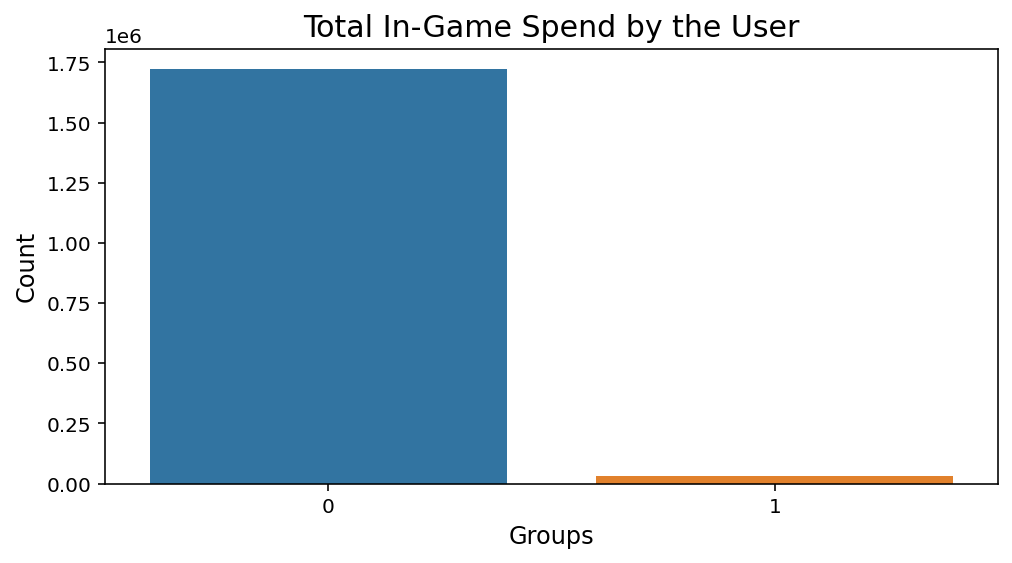

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(8,4))
sns.countplot(x='total_spend',data=df_final)
plt.title('Total In-Game Spend by the User',fontsize=15)
plt.xlabel('Groups',fontsize=12)
plt.ylabel('Count',fontsize=12)

As it is seen from this plot our dataset is highly imbalanced. So I should use some methods to reduce the effect of imbalanced dataset on the result of the prediction. I will discuss more about it later.

In [ ]:
#Find different categories and their number in the column 
df_final['lang_s'].value_counts()

ZH-CN    641834
EN       639267
ES       153934
PT        81966
RU        52277
FR        29967
JA        28463
TR        26238
IT        25075
DE        18111
ZH-TW     13848
ID         9522
AR         9311
TH         9206
KO         8339
NL         3604
NO          642
Name: lang_s, dtype: int64

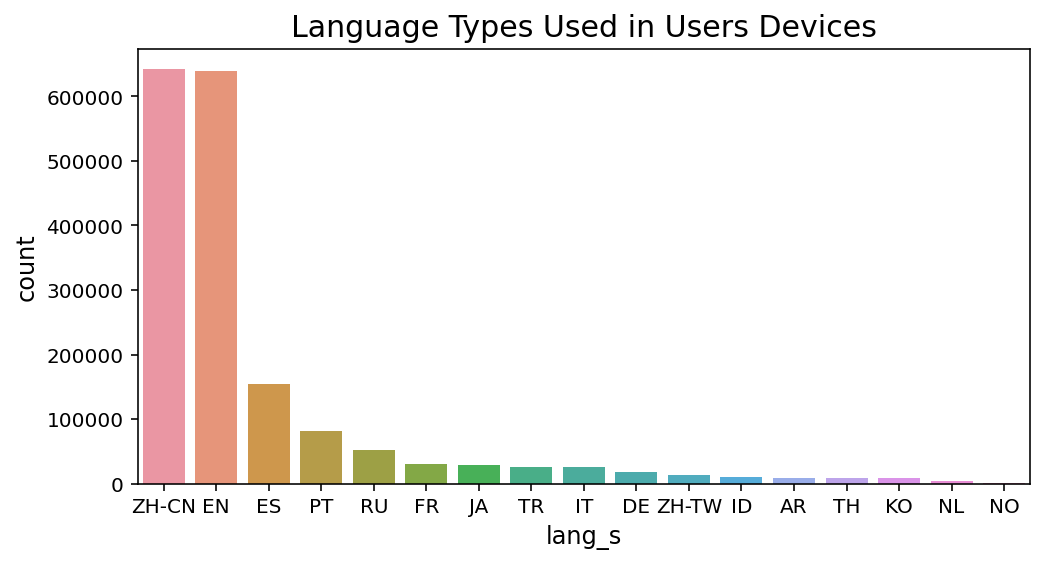

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(8,4))
plt.title('Language Types Used in Users Devices',fontsize=15)
plt.xlabel('Language',fontsize=12)
plt.ylabel('Count',fontsize=12)
sns.countplot(x='lang_s',data=df_final,order = df_final['lang_s'].value_counts().index)

As it is seen from the plot, Chinese, English and Spanish are the top 3 categories, respectively. I will make a group for all remaining categories.

In [ ]:
#make "other" category for the ones which do not belong to the top 3 categories
df_final.loc[~df_final['lang_s'].str.contains('ZH-CN|EN|ES',na=False),'lang_s']='other'

Now the new countplot will be as follows. We will have less categories which help us to reduce the size of dataset while converting the categorical variables to numerical variables.

In [ ]:
#add percentage of hue on the top of each category
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

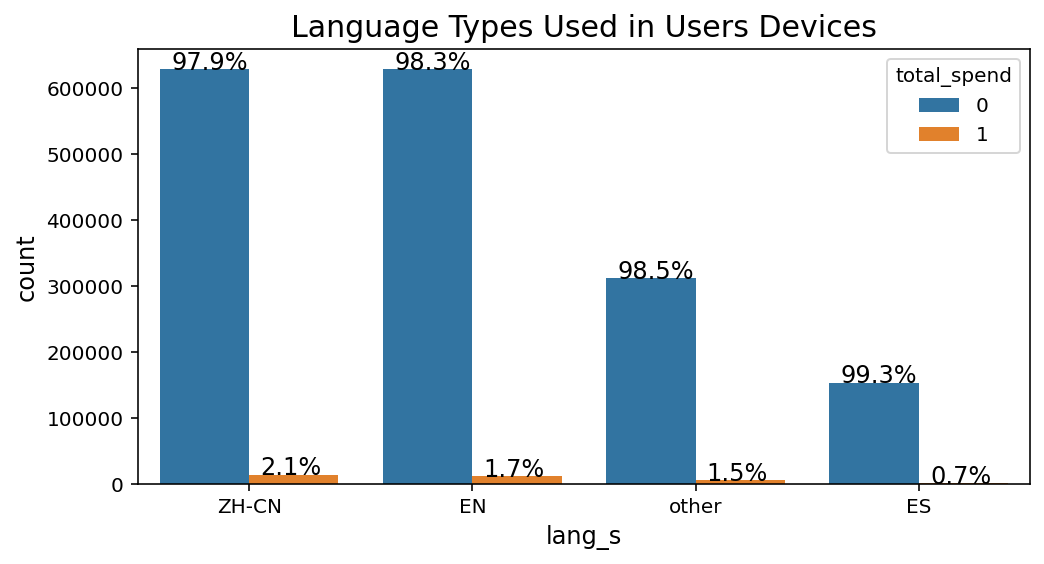

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(8,4))
plt.title('Language Types Used in Users Devices',fontsize=15)
plt.xlabel('Language',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='lang_s',hue='total_spend',data=df_final,order = df_final['lang_s'].value_counts().index)
with_hue(ax,df_final['lang_s'],4,2)

As it is seen in the plot above a larger proportion of users who are using devices with Chinese language are more likely to spend in-game.

In [ ]:
#Find different categories and their number in the column 
df_final['geo_s'].value_counts()

CN    652368
US    196398
BR    108151
IN     86058
MX     84638
       ...  
FK         2
WF         1
KM         1
SJ         1
NR         1
Name: geo_s, Length: 218, dtype: int64

We have 218 categories in 'geo_s' column. As I mentioned before, I will make a seperate group for the ones which do not belong to the top 3 categories. Comparing individual countries, China, US and Brazil have the most users in our dataset. In addition, I study the percentage of spending and non-spending users in each category. It seems that a larger proportion of users in US category are likely to spend in-game after finishing the tutorial.

In [ ]:
#make an "other" category for the ones which are not belongs to the top 3 categories
df_final.loc[~df_final['geo_s'].str.contains('CN|US|BR',na=False),'geo_s']='other'

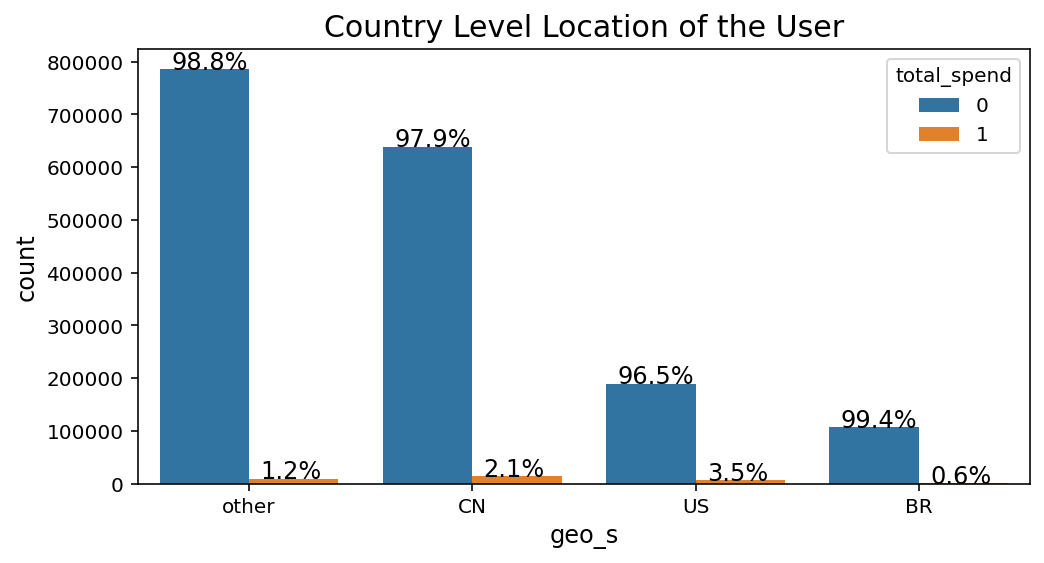

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(8,4))
plt.title('Country Level Location of the User',fontsize=15)
plt.xlabel('Country Level',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='geo_s',data=df_final,hue='total_spend')
with_hue(ax,df_final['geo_s'],4,2)

It can be seen that the country level of most users are from other countries. Then China and US have most users, respectively.

In [ ]:
#Find different categories and their number in the column 
df_final['region_s'].value_counts()

asia        972683
americas    494458
europe      255779
oceania      15957
africa       12727
Name: region_s, dtype: int64

Most of the users are from Asian countries then American countries.

In [ ]:
 #make an "other" category for the ones which are not belongs to the top 3 categories
 df_final.loc[~df_final['region_s'].str.contains('asia|americas|europe',na=False),'region_s']='other'

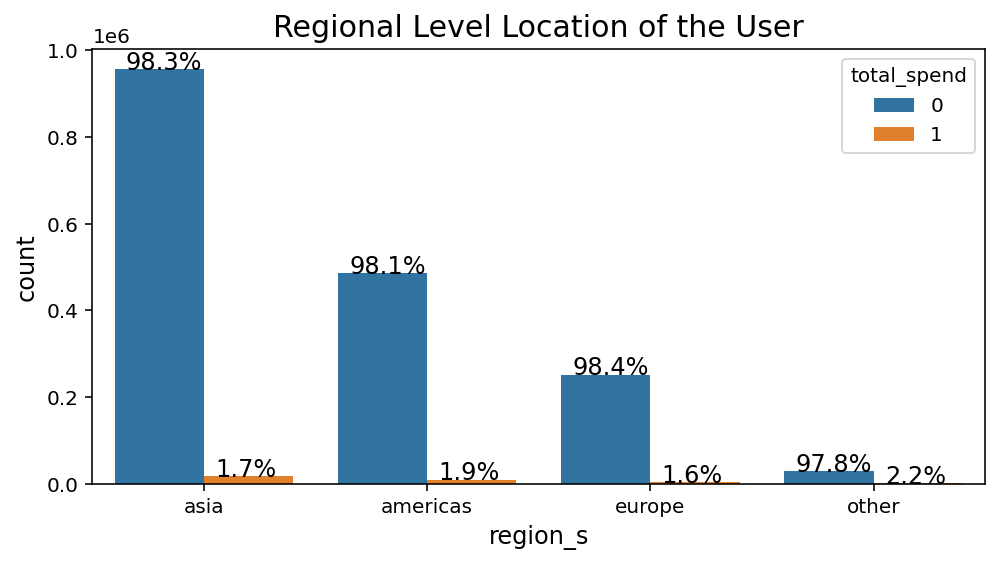

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(8,4))
plt.title('Regional Level Location of the User',fontsize=15)
plt.xlabel('Regional Level',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='region_s',data=df_final,hue='total_spend')
with_hue(ax,df_final['region_s'],4,2)

The percentage of users who are likey to spend in-game is more in other countries then in Americas.

In [ ]:
#Find different categories and their number in the column 
df_final['platform_s'].value_counts()

android    1322425
iphone      429179
Name: platform_s, dtype: int64

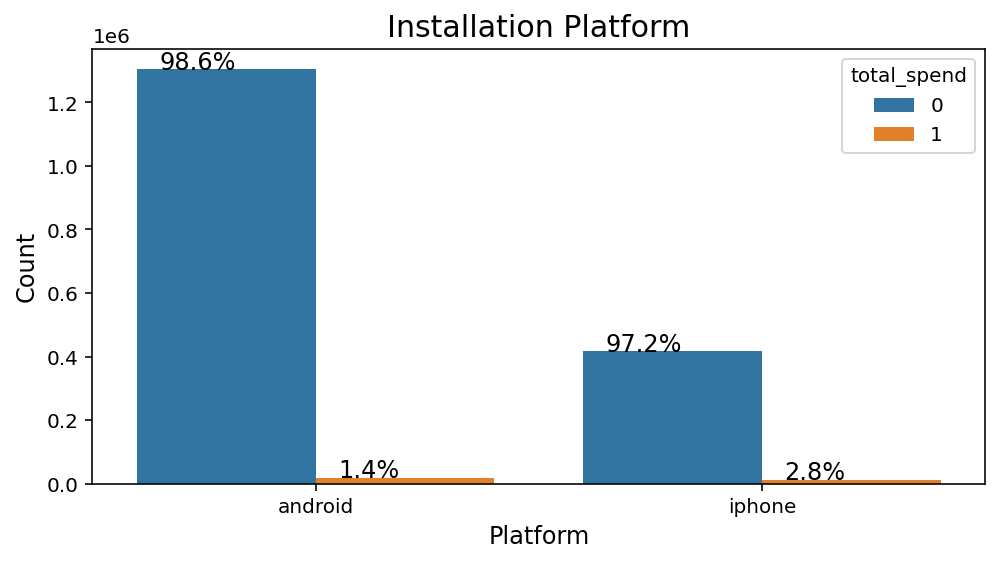

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(8,4))
plt.title('Installation Platform',fontsize=15)
ax=sns.countplot(x='platform_s',data=df_final,hue='total_spend')
plt.xlabel('Platform',fontsize=12)
plt.ylabel('Count',fontsize=12)
with_hue(ax,df_final['platform_s'],2,2)

Most of users are using Android as installation platform. But a larger proportion of the ones who have iphone are more likely to spend in-game after tutorial.

In [ ]:
#Find different categories and their number in the column 
df_final['device_mapped_s'].value_counts() 

iphone8,1           37847
iphone 6            30565
iphone9,3           26906
iphone 5s           26353
iphone11,8          24313
                    ...  
7qa_3g                  1
xplorer_10              1
a1q                     1
ms45s_a6_teen           1
itel a16 plus ru        1
Name: device_mapped_s, Length: 14098, dtype: int64

'device_mapped_s' has 14098 categories. As it is seen from the previous step, we have another column in our dataset as 'platform_s' which gives us a broader information about the platform that the users are using for installation. So, I decided not to consider this variable in the final dataset.

In [ ]:
#Find different categories and their number in the column 
df_final['device_manufacturer_s'].value_counts() 

apple         429179
samsung       346957
oppo          282142
huawei        227698
xiaomi        104926
               ...  
cellc              1
s471               1
a10 pro            1
hanzhong           1
mate10 pro         1
Name: device_manufacturer_s, Length: 2047, dtype: int64

In [ ]:
#Find different categories and their number in the column 
df_final['device_os_s'].value_counts() 

ios 12.2                                                       278082
ios 12.1.4                                                      36363
android os 6.0.1 / api-23 (mmb29m/eng.root.20190124.100902)     20199
android os 8.1.0 / api-27 (opm1.171019.026/1553937771)          19689
android os 6.0.1 / api-23 (mmb29m/eng.root.20181206.121003)     18280
                                                                ...  
android os 5.1 / api-22 (lmy47d/421)                                1
android os 6.0 / api-23 (mra58k/1532504912)                         1
android os 5.0.2 / api-21 (lrx22g/150651744a25e)                    1
android os 6.0 / api-23 (mra58k/1483758884)                         1
android os 7.0 / api-24 (nrd90m/ww_p028-v3.3.3-20170808)            1
Name: device_os_s, Length: 56492, dtype: int64

In [ ]:
#Find different categories and their number in the column 
df_final['device_model_s'].value_counts() #drop

iphone8,1            37847
iphone7,2            30564
iphone9,3            26906
iphone11,8           24313
oppo a57             19025
                     ...  
mi-so02-81t              1
q9plus                   1
max 5                    1
oplus_compact_pro        1
s107                     1
Name: device_model_s, Length: 14194, dtype: int64

As it is seen from the value_count results of 'device_manufacturer_s', 'device_os_s', and 'device_model_s', they have more than 1000 categories and they contain almost same information as 'platform_s' column. So, I will drop them in the future step.

In [ ]:
#Find different categories and their number in the column 
df_final['game_stats_tutorial_complete'].value_counts()

1.0    1751604
Name: game_stats_tutorial_complete, dtype: int64

It means that all users in the current dataset (after removing NaN values) complete the tutorial. We can drop this column for the final dataset as it has same information for all users.

In [ ]:
#Find different categories and their number in the column 
df_final['device_gpu_s'].value_counts()

adreno (tm) 506                                                             137593
mali-t830                                                                   127130
mali-t720                                                                   102215
apple a10 gpu                                                                90875
adreno (tm) 505                                                              84927
                                                                             ...  
mumu gl (intel inc. intel iris opengl engine opengl 4.1 core)                    1
mumu gl (intel inc. intel(r) iris(tm) plus graphics 655 opengl 4.1 core)         1
mumu gl (amd radeon (tm) r9 360 direct3d11 vs_5_0 ps_5_0)                        1
angle (intel(r) hd graphics 630 direct3d11 vs_5_0 ps_5_0)                        1
angle (intel(r) q45/q43 express chipset direct3d11 vs_4_0 ps_4_0)                1
Name: device_gpu_s, Length: 426, dtype: int64

We can drop this feature later as 'device_mem_grouping_i', 'device_gmem_grouping_i' and 'device_numcpu_i' have almost same information and they give us important information about memory size, graphical memory and number of CPU cores. 

Since game experience mostly depends on the CPU/GPU/MEMOMRY capacity of devices, I will keep these features in dataset.

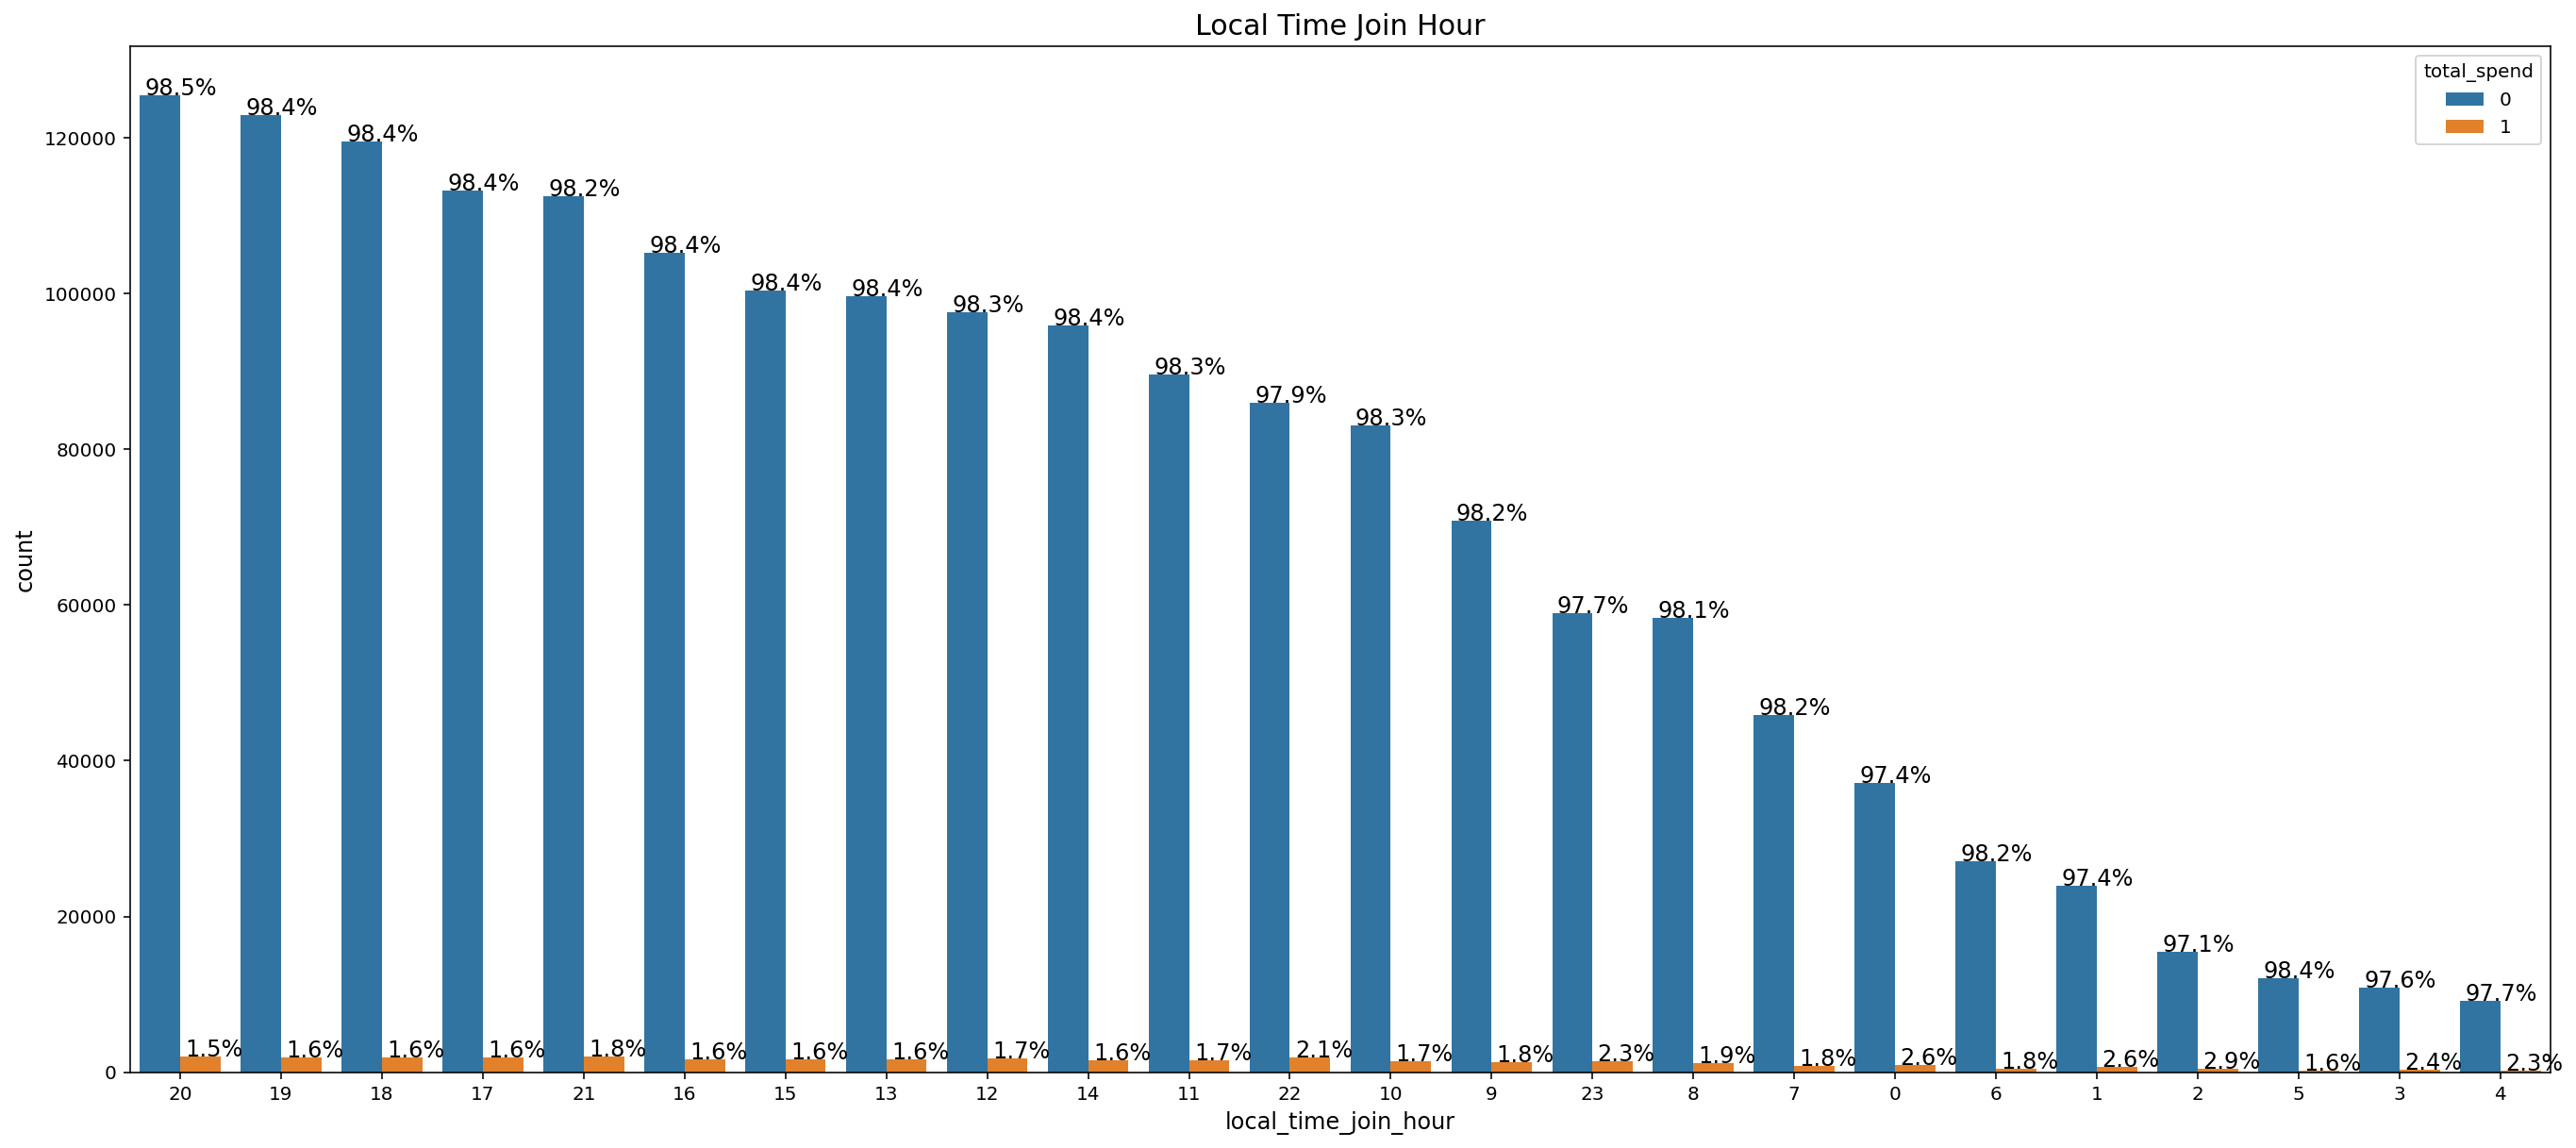

In [ ]:
#Countplot which shows the time that users join
plt.figure(figsize=(23,10))
plt.title('Local Time Join Hour',fontsize=15)
plt.xlabel('Local Time',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='local_time_join_hour',hue='total_spend',data=df_final,order = df_final['local_time_join_hour'].value_counts().index)
with_hue(ax,df_final['local_time_join_hour'],24,2)

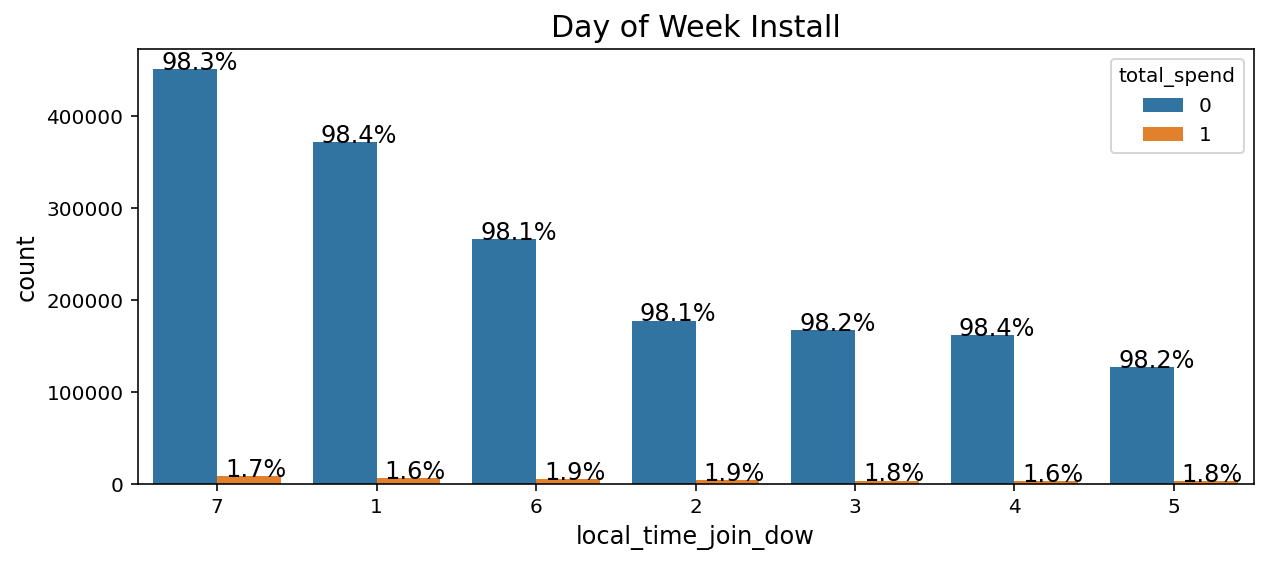

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(10,4))
plt.title('Day of Week Install',fontsize=15)
plt.xlabel('Day',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='local_time_join_dow',hue='total_spend',data=df_final,order = df_final['local_time_join_dow'].value_counts().index)
with_hue(ax,df_final['local_time_join_dow'],7,2)

The number of users that join increases from 6:00 am until 8:00 pm then it starts decreasing again. Number of users who join around 8:00 pm is the highest. And the number of users who join on day 7 is the highest among the other days. In addition, a larger proportion of people who joind at 2:00 am and a larger proportion of users who join at days 6 and day 2 are likely to spend in-game, but the differences are not large.

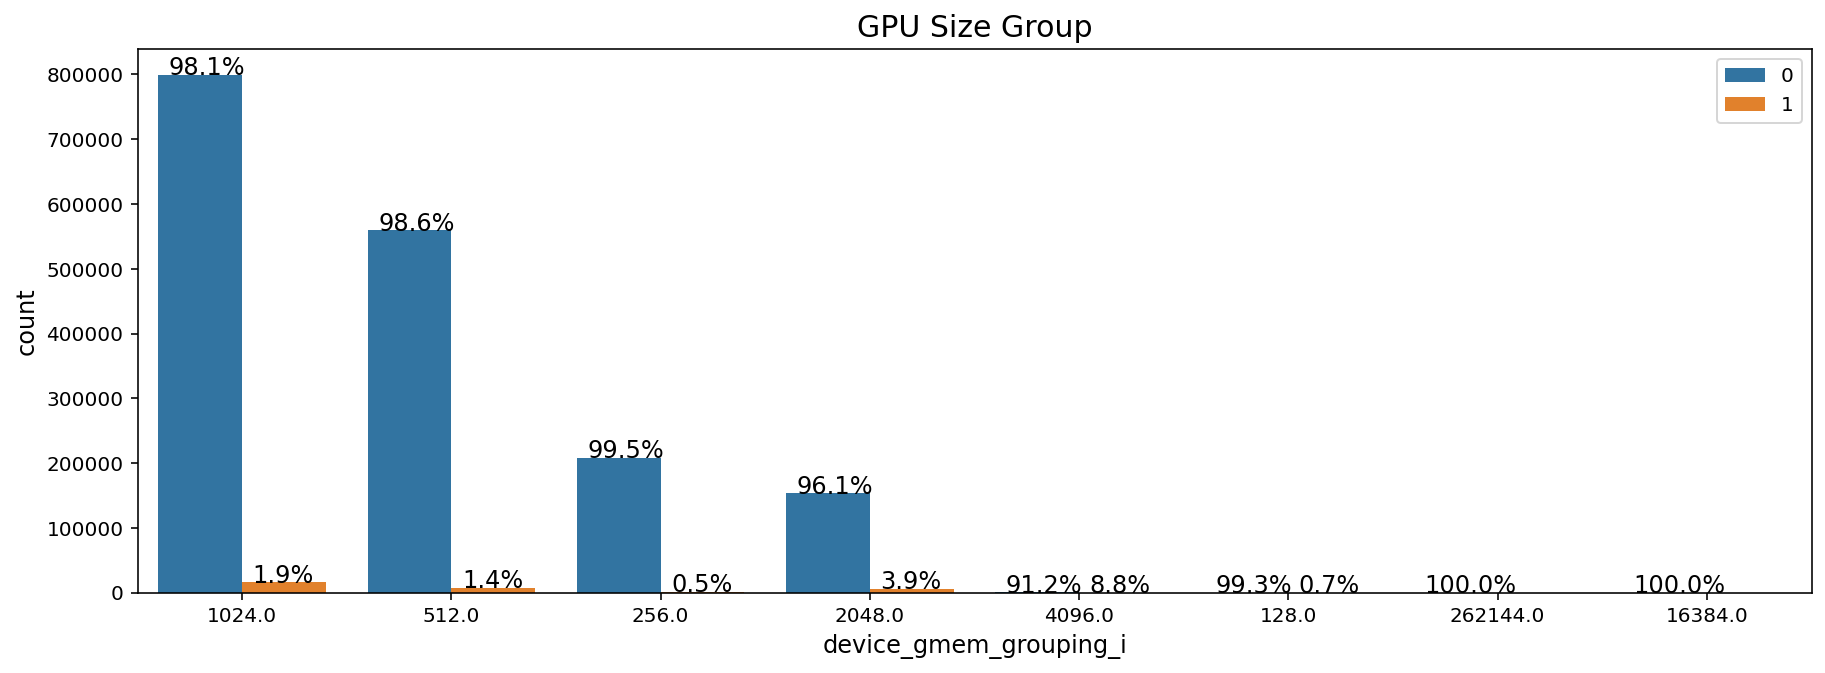

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(15,5))
plt.title('GPU Size Group',fontsize=15)
plt.xlabel('GPU Size',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='device_gmem_grouping_i',hue='total_spend',data=df_final,order = df_final['device_gmem_grouping_i'].value_counts().index)
ax.legend(loc='upper right')
with_hue(ax,df_final['device_gmem_grouping_i'],8,2)

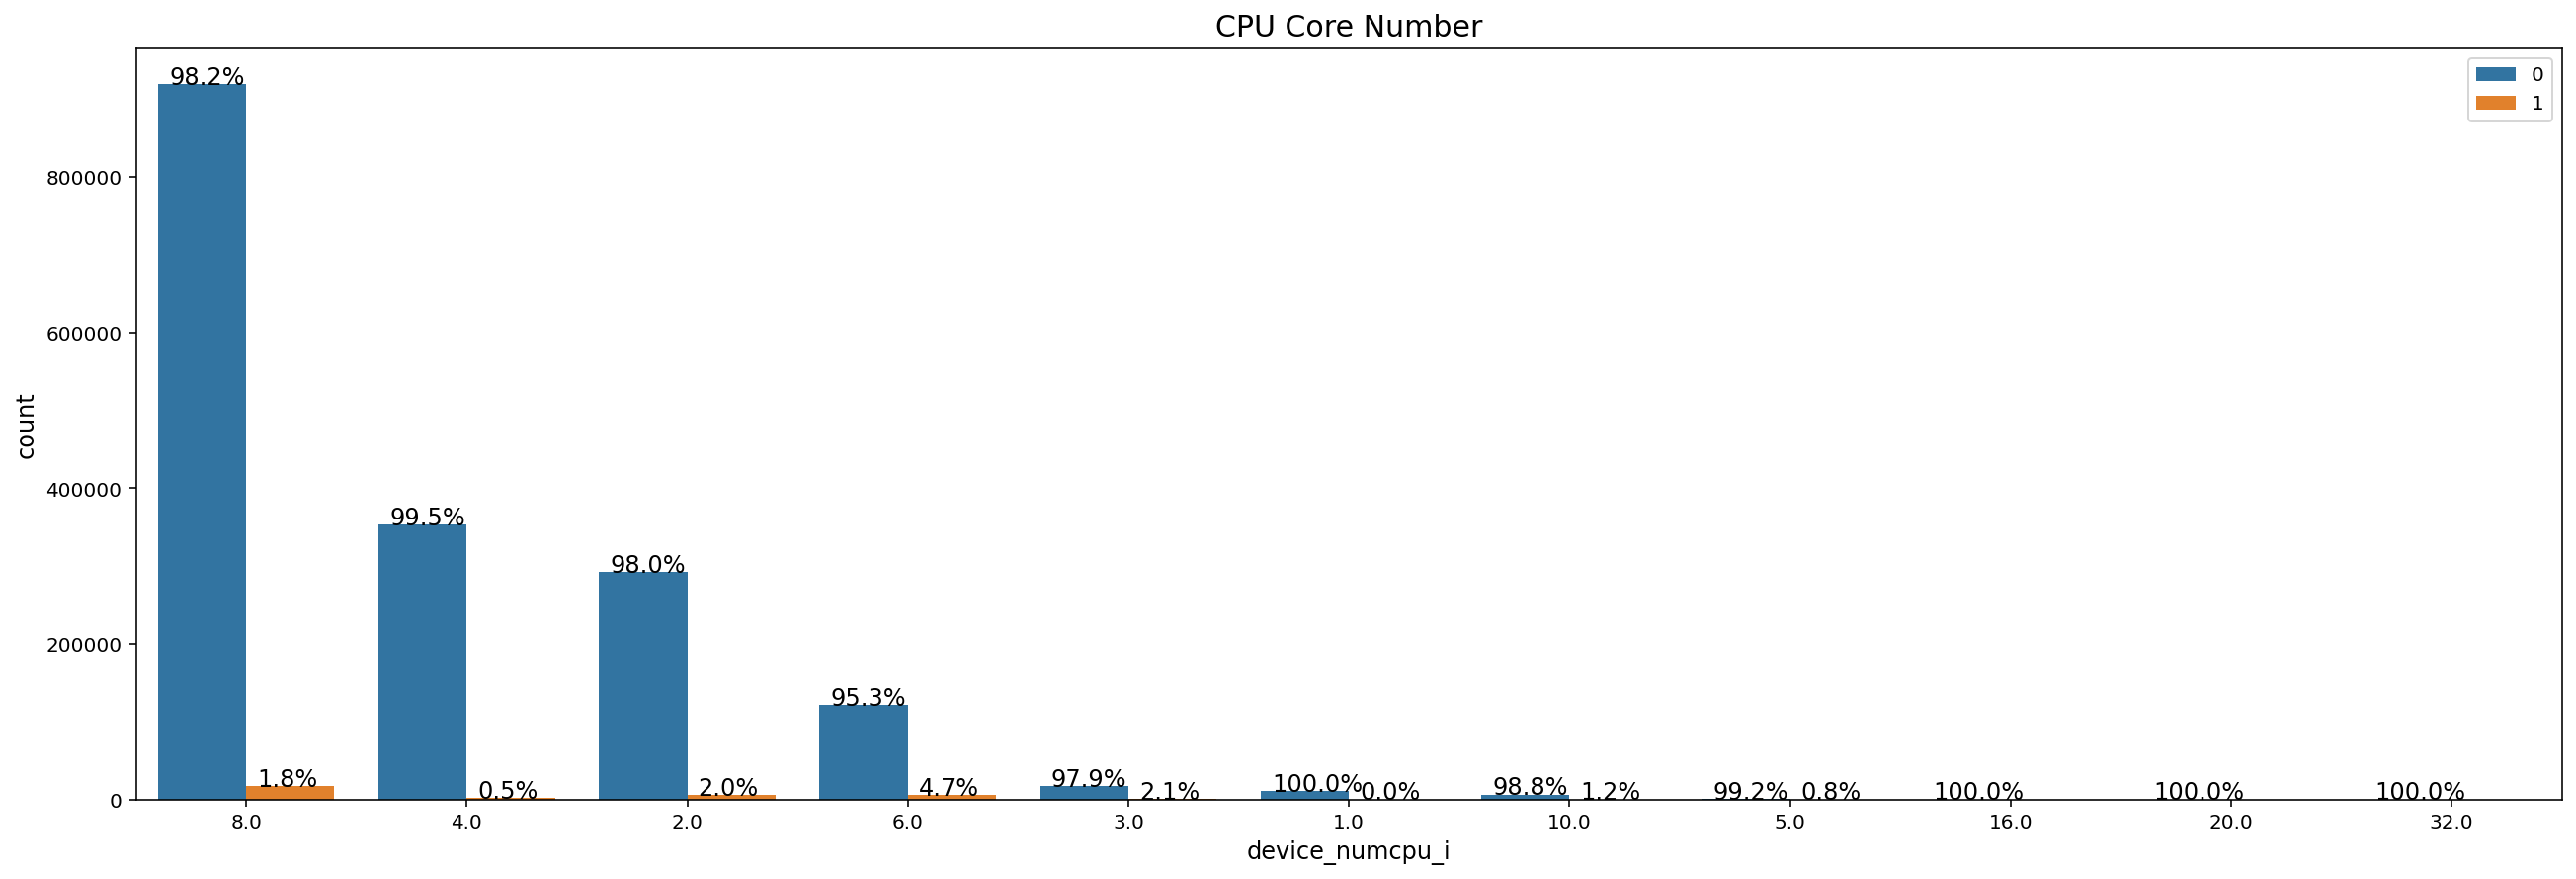

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(22,7))
plt.title('CPU Core Number',fontsize=15)
plt.xlabel('CPU Core ',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='device_numcpu_i',hue='total_spend',data=df_final,order = df_final['device_numcpu_i'].value_counts().index)
ax.legend(loc='upper right')
with_hue(ax,df_final['device_numcpu_i'],11,2)

As it can be seen from the above plots, users with the devices that have  6 CPU cores are more likely to spend in-game. On the other hand, users with 4 CPU cores are less likely to spend in-game compared to the other four most common CPU core counts. In addition, users with devices that have GPU memory of 4096 MB are much more likely to spend in-game, followed by users with 2048 MB of GPU memory.

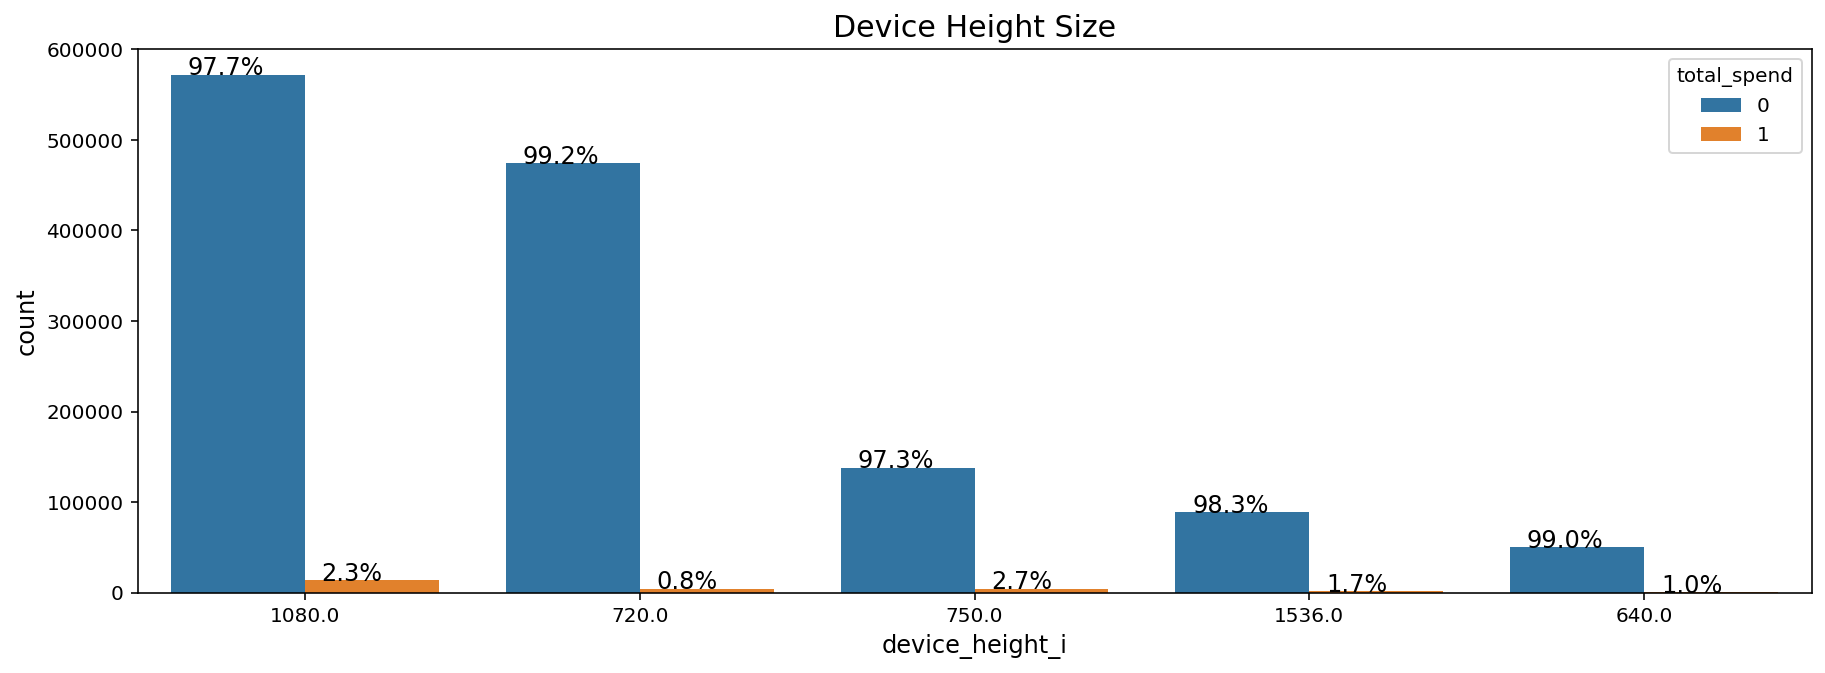

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(15,5))
plt.title('Device Height Size',fontsize=15)
plt.xlabel('Height Size',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='device_height_i',hue='total_spend',data=df_final,order = df_final['device_height_i'].value_counts().iloc[:5].index)
with_hue(ax,df_final['device_height_i'],5,2)

Highest proportion of users with device height size of 750 are more likely to spend in-game, followed closley by users with device height size of 1080. Users with device height of 720 are proportianlly less likely to spend in-game, compared other four most common device height sizes. 

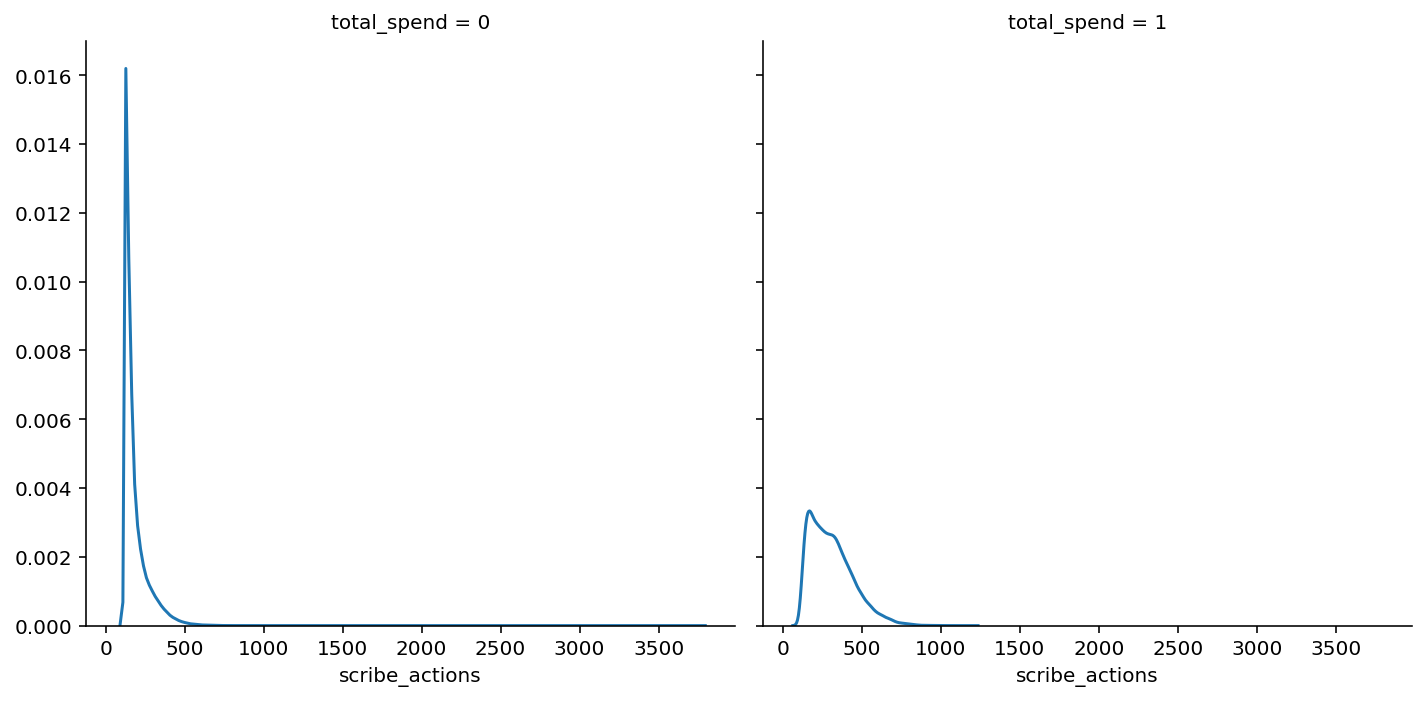

In [ ]:
#distribution of feature based  on total spend category
g = sns.FacetGrid(df_final, col="total_spend",height=5)
g.map(sns.kdeplot, "scribe_actions")

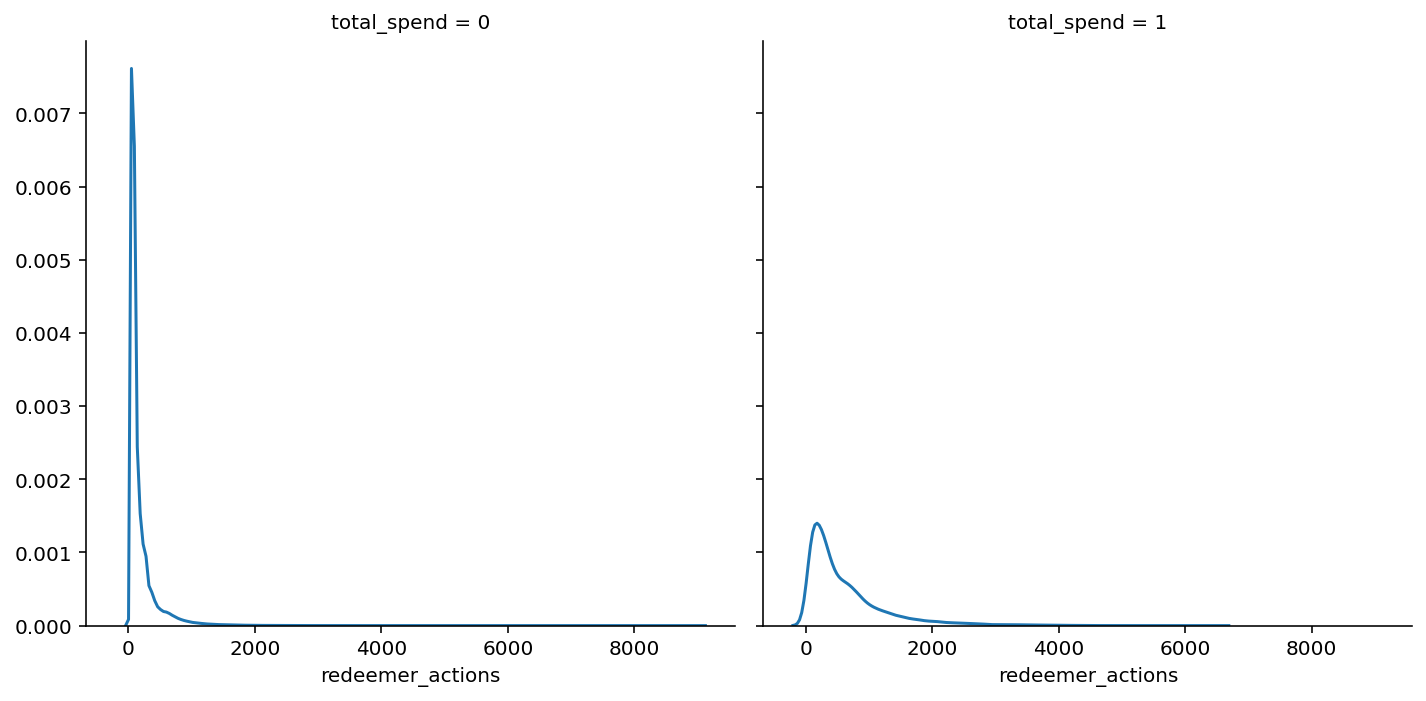

In [ ]:
#distribution of feature based  on total spend category
g = sns.FacetGrid(df_final, col="total_spend",height=5)
g.map(sns.kdeplot, "redeemer_actions")

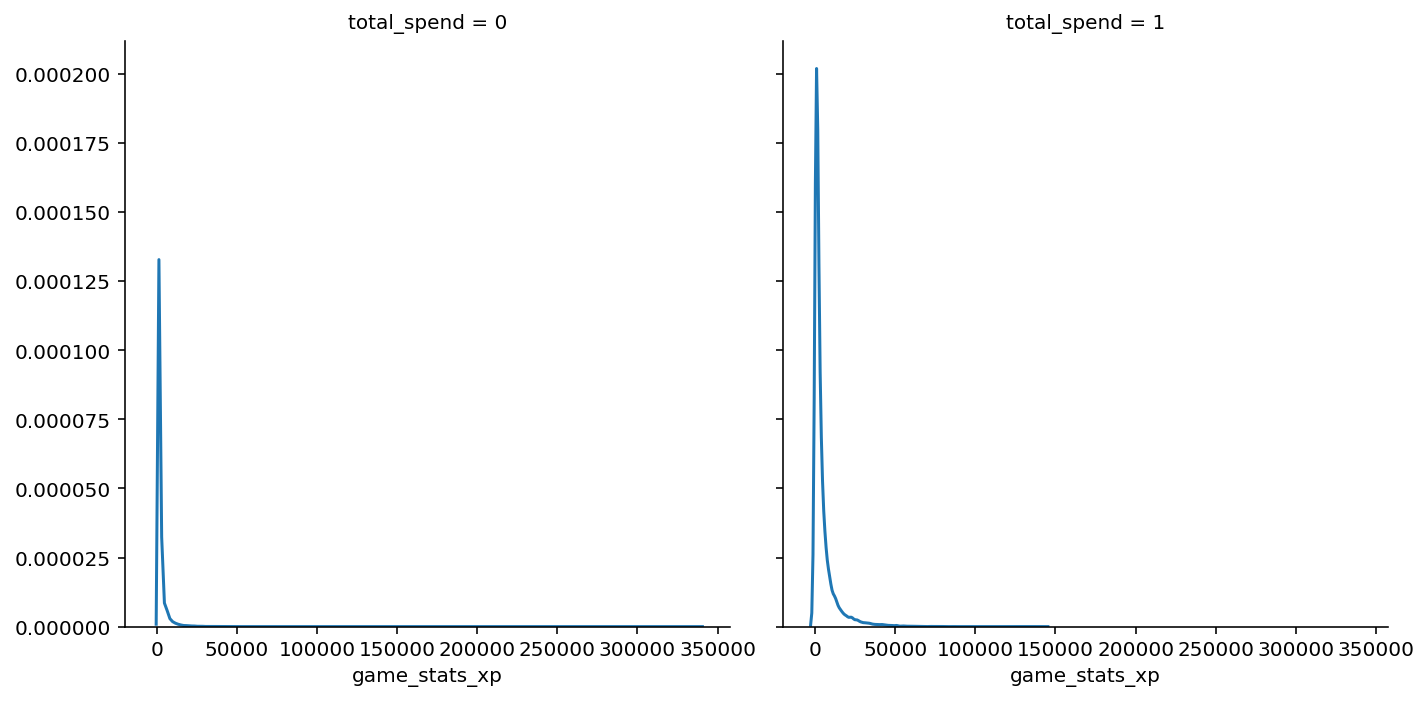

In [ ]:
#distribution of feature based  on total spend category
g = sns.FacetGrid(df_final, col="total_spend",height=5)
g.map(sns.kdeplot, "game_stats_xp")

The distribution plots of 'game_stats_xp', 'redeemer_actions', and 'scribe_actions' have similar patterns between the two different 'total_spend' categories (spend or not spend). In the following steps, I plot the countplot of the top categories of each feature to get a better insight into the data.

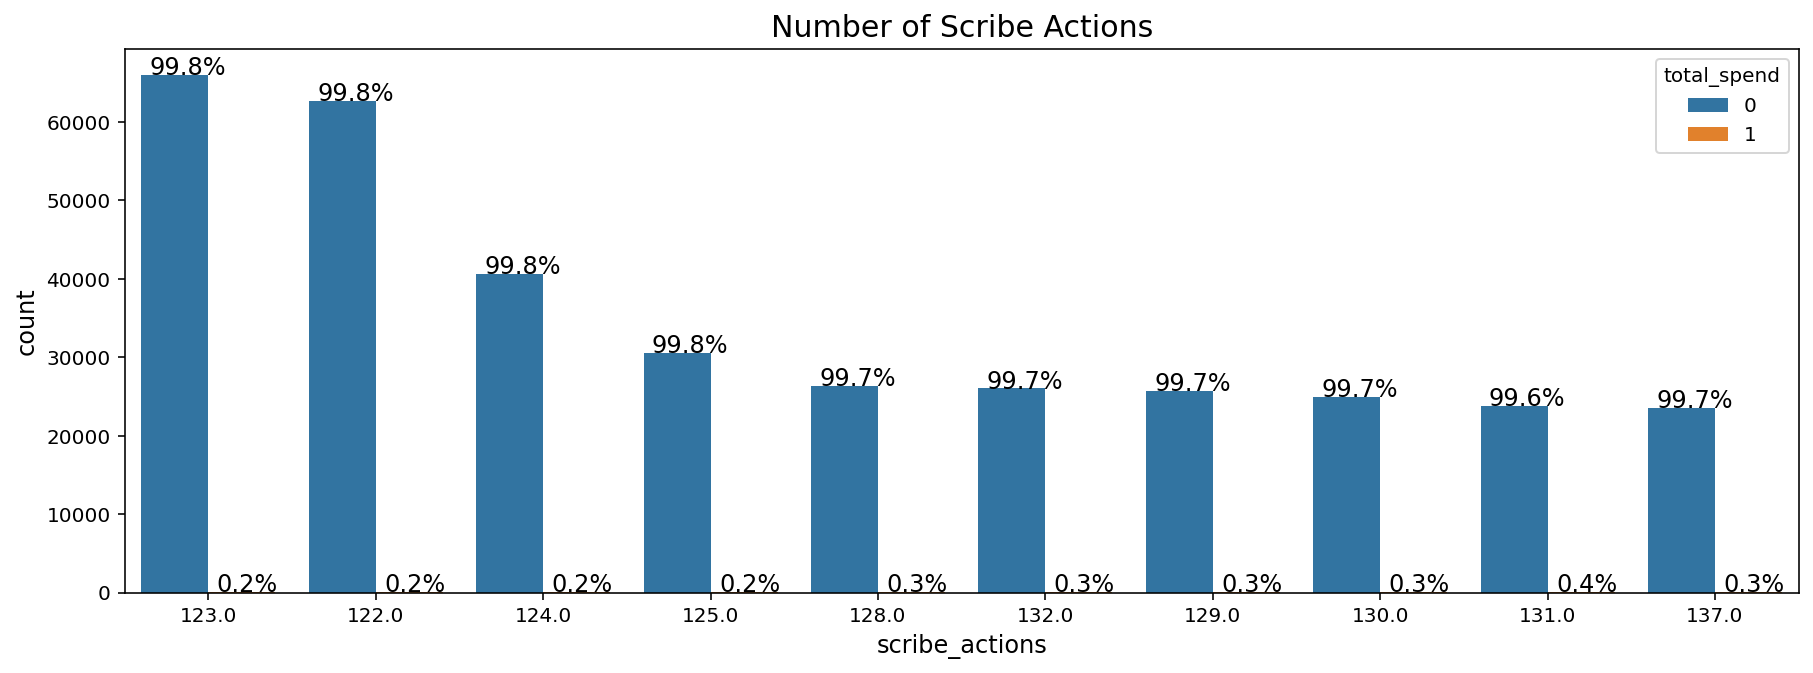

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(15,5))
plt.title('Number of Scribe Actions',fontsize=15)
plt.xlabel('Scribe Actions',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='scribe_actions',hue='total_spend',data=df_final,order = df_final['scribe_actions'].value_counts().iloc[:10].index)
with_hue(ax,df_final['scribe_actions'],10,2)

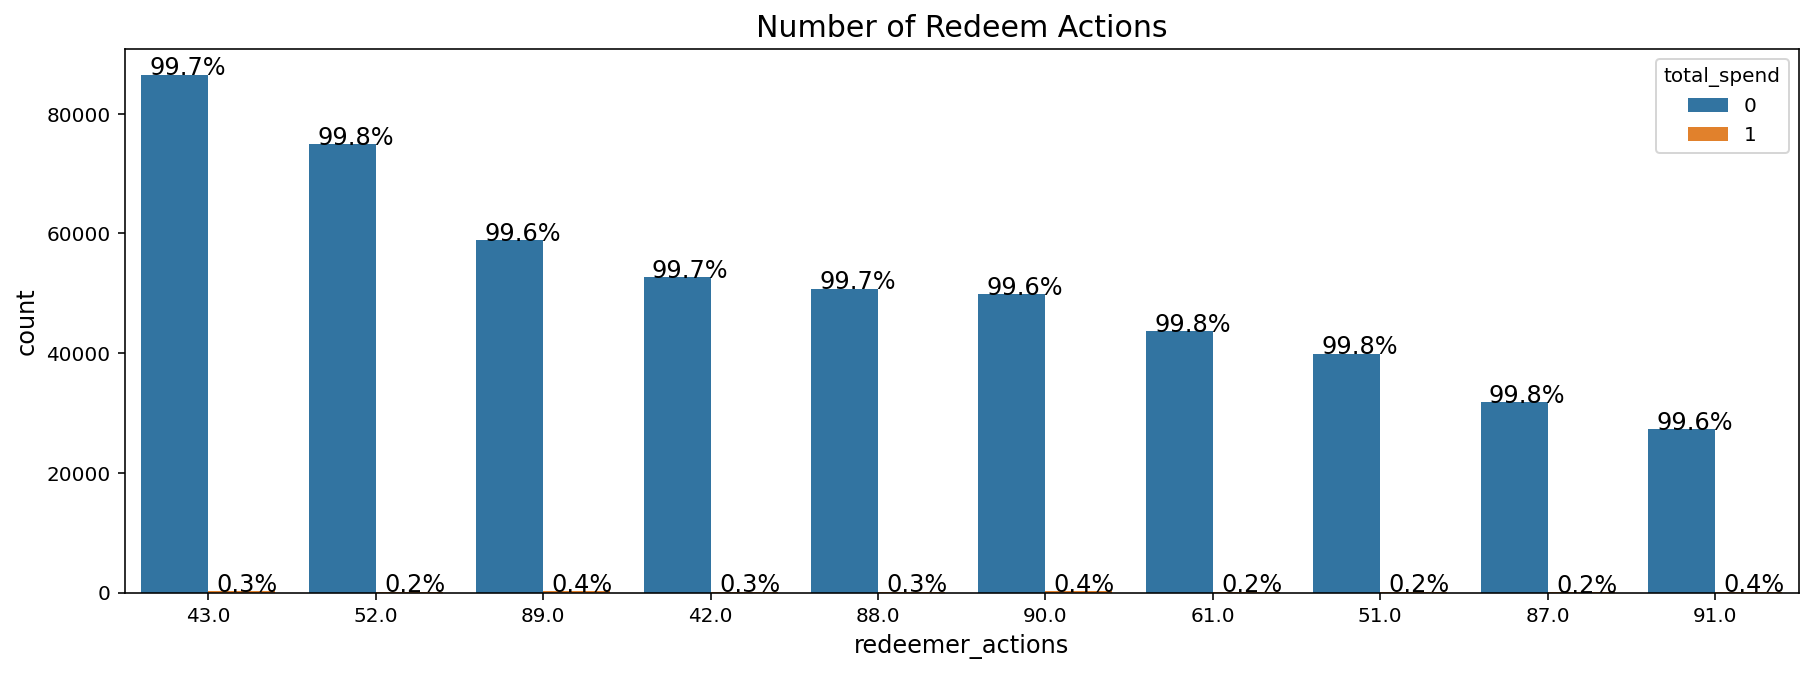

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(15,5))
plt.title('Number of Redeem Actions',fontsize=15)
plt.xlabel('Redeem Actions',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='redeemer_actions',hue='total_spend',data=df_final,order = df_final['redeemer_actions'].value_counts().iloc[:10].index)
with_hue(ax,df_final['redeemer_actions'],10,2)

The proportion of users who are likely to spend in-game slightly increases as the number of 'scribe_actions' and 'redeemer_actions' increases.

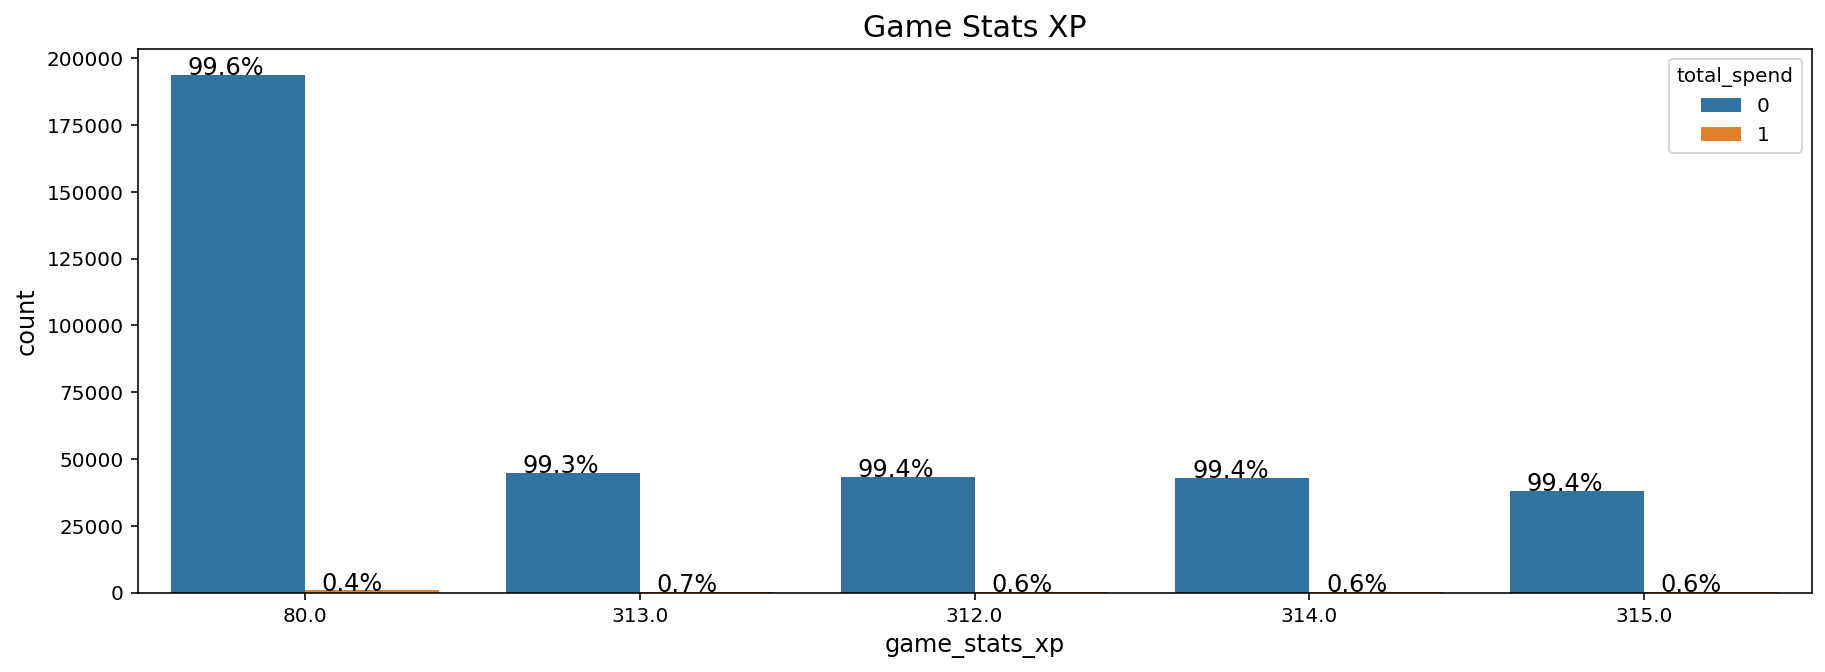

In [ ]:
#countplot which shows different categories and their counts
plt.figure(figsize=(15,5))
plt.title('Game Stats XP',fontsize=15)
plt.xlabel('Game Stats',fontsize=12)
plt.ylabel('Count',fontsize=12)
ax=sns.countplot(x='game_stats_xp',hue='total_spend',data=df_final,order = df_final['game_stats_xp'].value_counts().iloc[:5].index)
with_hue(ax,df_final['game_stats_xp'],5,2)

As it is seen from 'game_stats_xp' countplot, users who accumulated more experience points by first time interval from install are more likely to spend in-game.

3- In the following steps, I will study the distribution of some of the continuous features. 

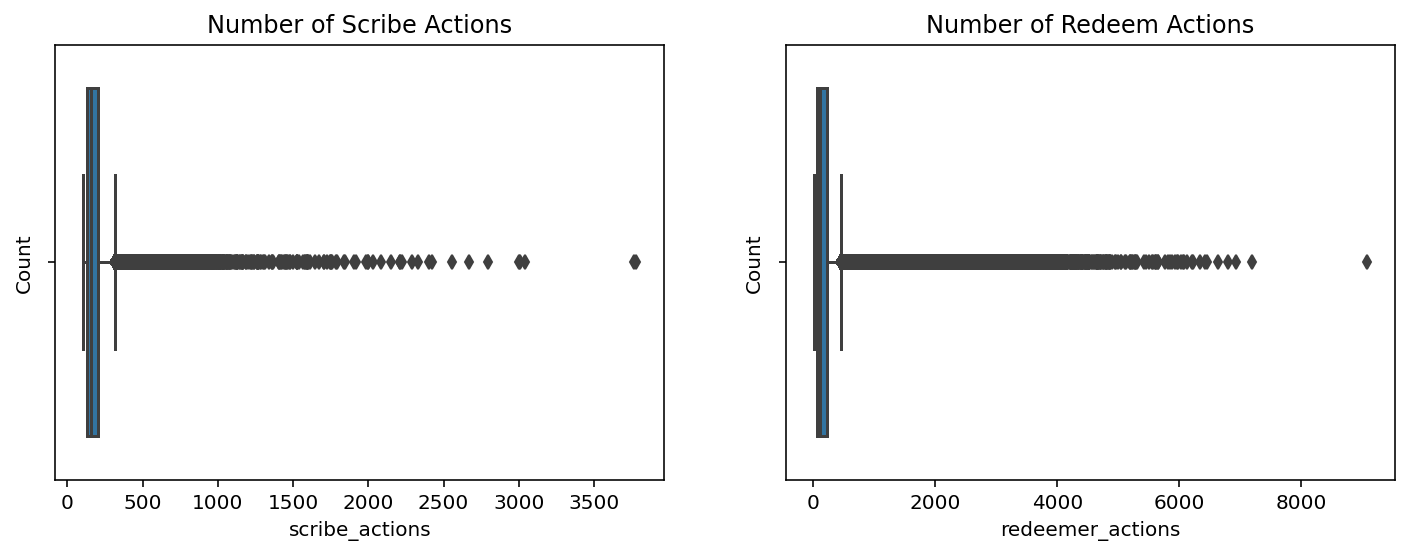

In [ ]:
#boxplot of two columns
f, axes = plt.subplots(ncols=2, figsize=(12,4))

sns.boxplot(x="scribe_actions", data=df_final, ax=axes[0])
axes[0].set_title('Number of Scribe Actions')
axes[0].set_ylabel('Count')
sns.boxplot(x="redeemer_actions", data=df_final, ax=axes[1])
axes[1].set_title('Number of Redeem Actions')
axes[1].set_ylabel('Count')
plt.show()

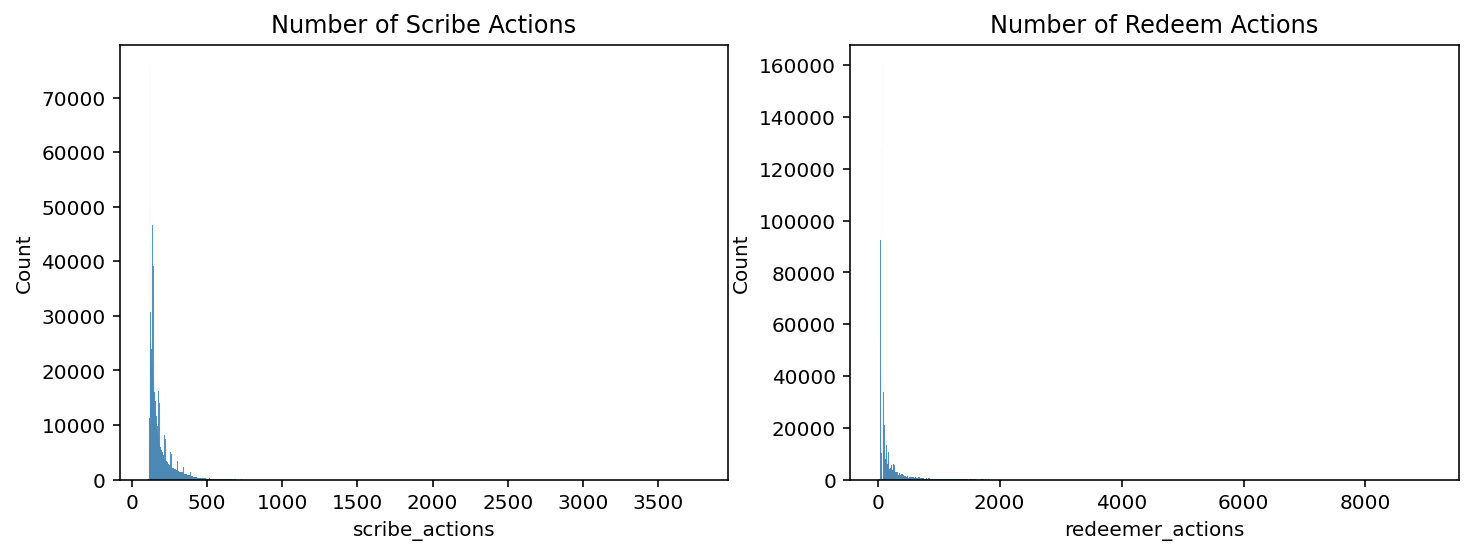

In [ ]:
#histplot of two columns
f, axes = plt.subplots(ncols=2, figsize=(12,4))

sns.histplot(x="scribe_actions", data=df_final, ax=axes[0])
axes[0].set_title('Number of Scribe Actions')
axes[0].set_ylabel('Count')
sns.histplot(x="redeemer_actions", data=df_final, ax=axes[1])
axes[1].set_title('Number of Redeem Actions')
axes[1].set_ylabel('Count')
plt.show()

As it is seen from the boxplot and histogram plots, the features are highly skewed and they have outliers. There are many ways to make the data more normalized such as using Box-Cox and Yeo-Johnson methods. Performance of some methods such as linear regression and logistic regression are affected by skewness and outliers in data but research shows that the performance of tree-based methods such as Random Forest are less impacted by the outliers. I will use Random Forest classifier which is more robust for outliers. 

4-As I mentioned before some of the column information is repetitive or it doesn't add valuable information, so we need to drop them before developing a Machine Learning model to reduce the computational cost. 'tz_i' shows the time zone, however many countries that have very different user behaviours have the same time zone, therefore I will drop the 'tz_i' column since it is not giving us important information.

In [ ]:
#drop columns with non valuable and repetive information.
list_drop=['tz_i','device_mapped_s','device_manufacturer_s','device_mem_i','device_gmem_i',
           'device_os_s','device_model_s','game_stats_tutorial_complete','uid_s','device_gpu_s']
df_final.drop(columns=list_drop,axis=1,inplace=True)

Now I will study the correlation between the remaining features. As it is seen in the correlation heatmap, 'game_stats_xp' and 'redeemer_actions' are highly correlated. We can drop one of the features which are highly correlated but I keep them since they have important information about user's experience.

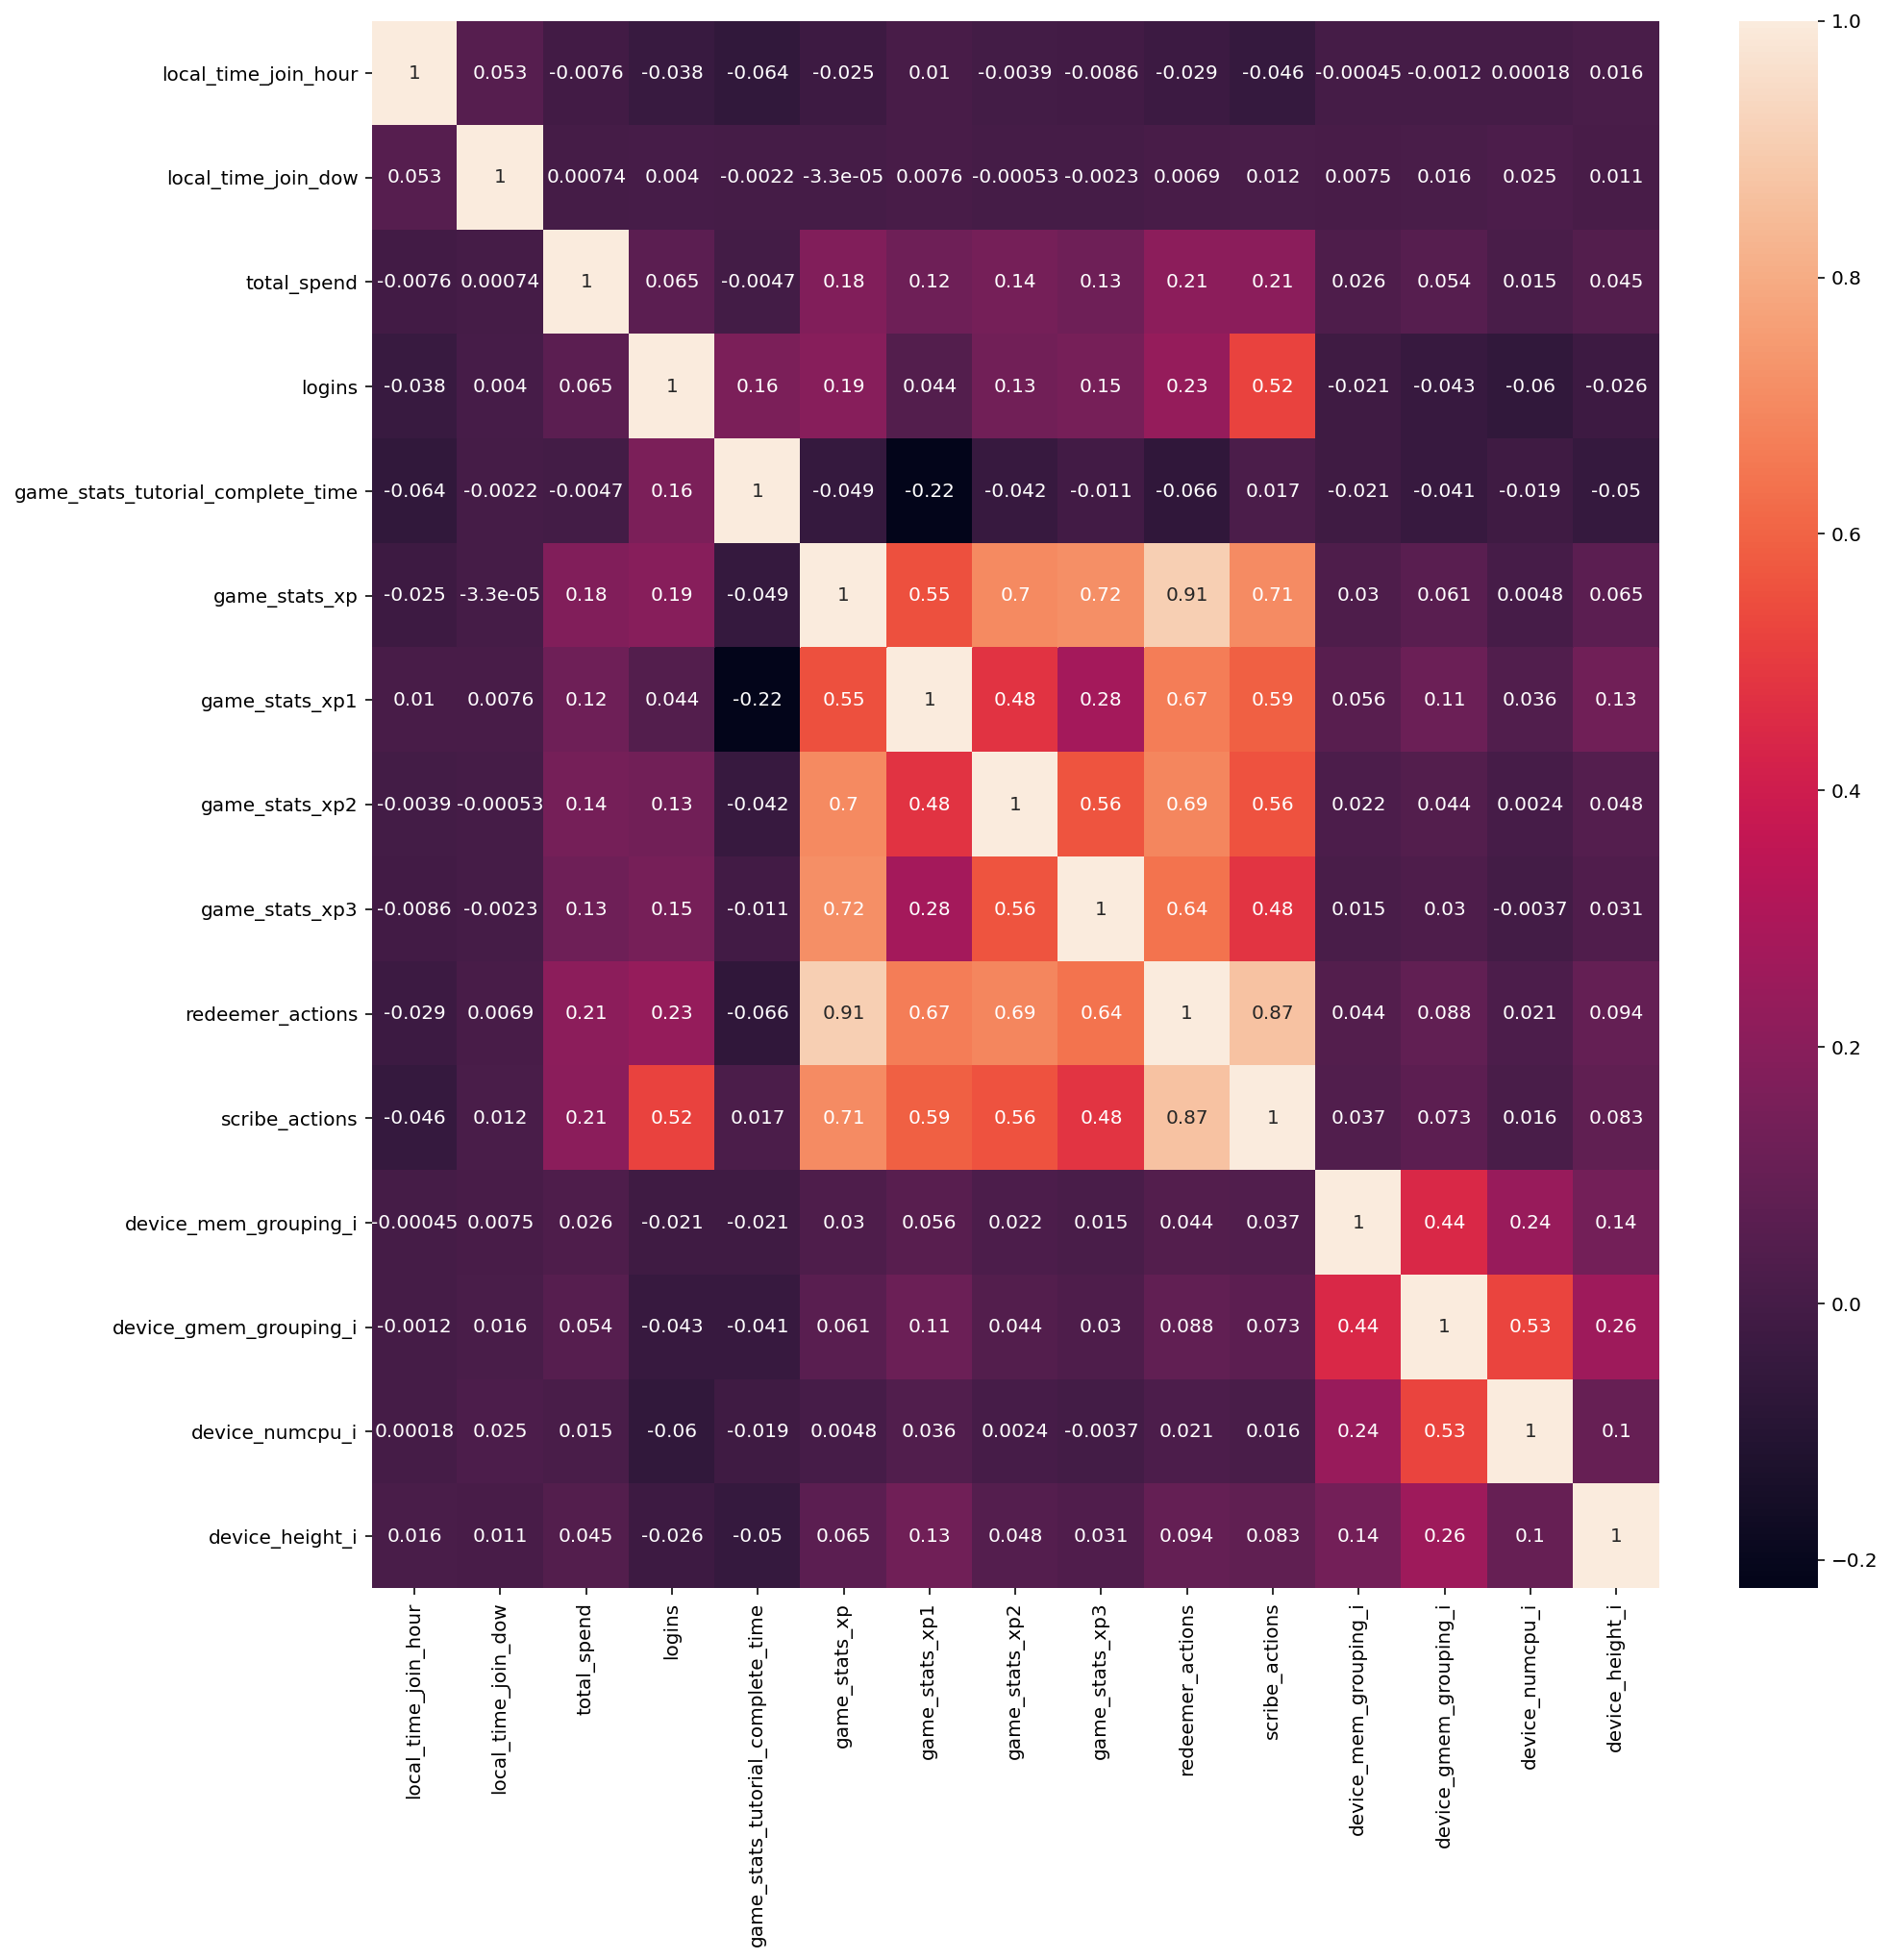

In [ ]:
#correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))         
sns.heatmap(df_final.corr(),annot=True,ax=ax)

5- We need to transform the categorical variables to numerical variables. I use get_dummies() method for this purpose. We can drop the first column to convert the variable to smaller size.

In [ ]:
# Transfer categorical variables to numerical values.
list_label=['lang_s','geo_s','region_s','platform_s']
df_final = pd.get_dummies(df_final, columns=list_label, drop_first=True)

6- We also have 'local_time_join_hour' variable which cannot be considered as categorical variable because it destroys any proximity measure (and ordering) among hours. So I use Cyclic variables. Cyclic variables map hours onto a circle (like a 24-h mechanical clock) so that the ML algorithm can see the neighbours of individual hours. 

In [ ]:
#use cyclic variable to map hours onto a circle.
df_final['local_time_join_hour_x']=np.sin(2.*np.pi*df_final['local_time_join_hour']/24.)
df_final['local_time_join_hour_y']=np.cos(2.*np.pi*df_final['local_time_join_hour']/24.)
df_final.drop(columns='local_time_join_hour',axis=1,inplace=True)

**Next part (7) should be done if one is using non tree-based algorithms.**

7- As it is seen, some of the variables have outliers and they are skewed. If data is skewed, it will affect the performance of the machine learning model. I compared some scaling methods to transform data into normal data, and Box-Cox had the best result.The Box-Cox transformation is also a technique to transform non-normal data into normal shape. It should be noted that Box-Cox works on positive data. 

In [ ]:
df_optional=df_final.copy()

In [ ]:
#list of columns where data is not normally distributed.
outlier_columns=['logins','game_stats_tutorial_complete_time', 'game_stats_xp', 'game_stats_xp1',
       'game_stats_xp2', 'game_stats_xp3', 'redeemer_actions','scribe_actions']

In [ ]:
#Check if all columns are positive
df_optional[outlier_columns].min()

logins                                       1.0
game_stats_tutorial_complete_time    228000000.0
game_stats_xp                                5.0
game_stats_xp1                               0.0
game_stats_xp2                               0.0
game_stats_xp3                               0.0
redeemer_actions                             1.0
scribe_actions                             104.0
dtype: float64

As it is seen from the above result, the minimum value of some columns is 0. I added a small amount to these columns to make them positive to prevent the error when using Box-Cox method.

We can compare the distribution plot and box plot of one of these columns before and after using Box-Cox to see the affect of this method on normalization.

Text(0, 0.5, 'Count')

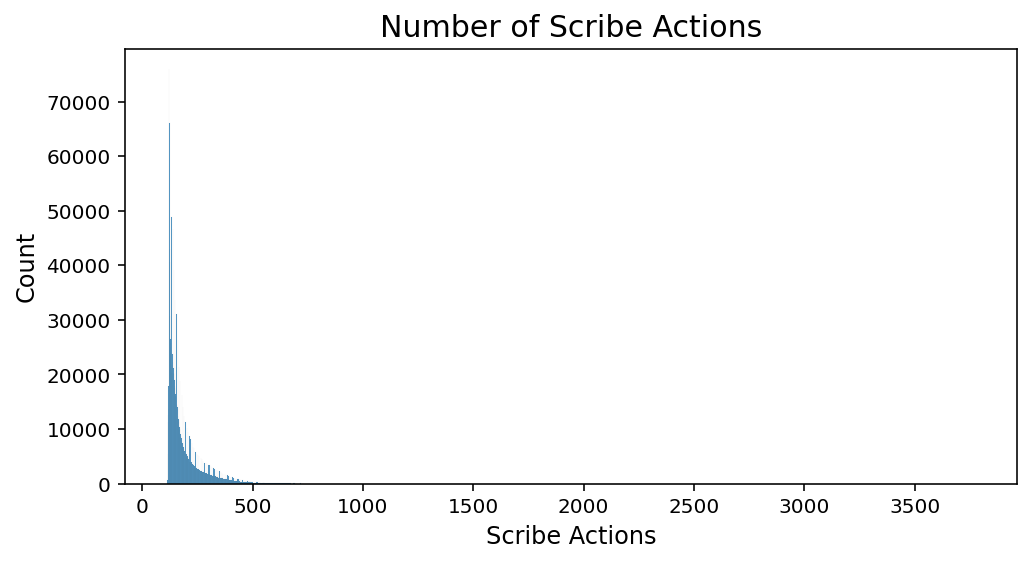

In [ ]:
#histogram plot which shows variable distribution 
plt.figure(figsize=(8,4))
sns.histplot(x='scribe_actions',data=df_optional)
plt.title('Number of Scribe Actions',fontsize=15)
plt.xlabel('Scribe Actions',fontsize=12)
plt.ylabel('Count',fontsize=12)

Text(0, 0.5, 'Count')

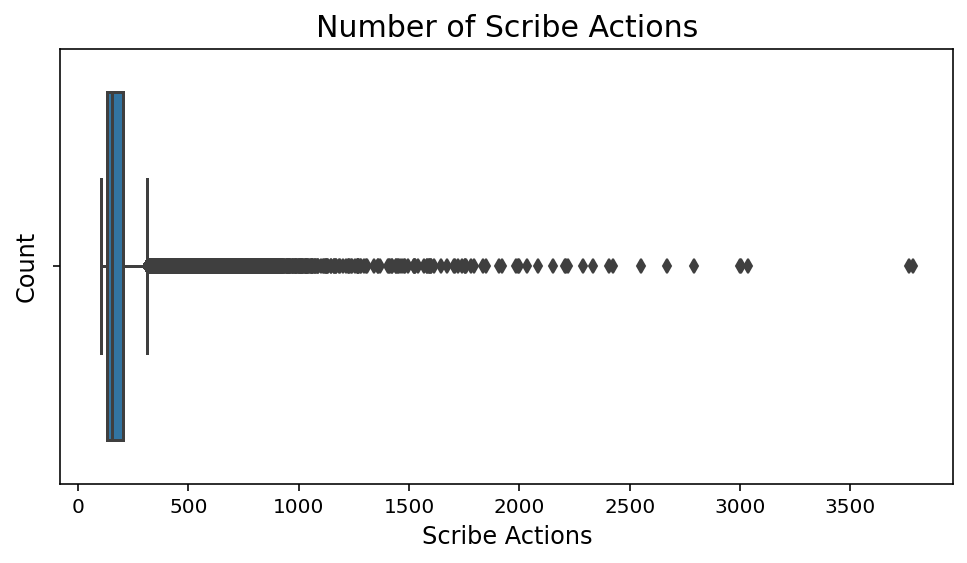

In [ ]:
#boxplot which shows the distribution of a variable
plt.figure(figsize=(8,4))
sns.boxplot(x='scribe_actions',data=df_optional)
plt.title('Number of Scribe Actions',fontsize=15)
plt.xlabel('Scribe Actions',fontsize=12)
plt.ylabel('Count',fontsize=12)

In [ ]:
c=0
for i in outlier_columns:
  if i in ['game_stats_xp1','game_stats_xp2','game_stats_xp3']:
    c=0.1
    df_optional[i],fitted_lambda= scipy.stats.boxcox(df_optional[i]+c ,lmbda=None)
  else:
    c=0
    df_optional[i],fitted_lambda= scipy.stats.boxcox(df_optional[i]+c ,lmbda=None)

Text(0, 0.5, 'Count')

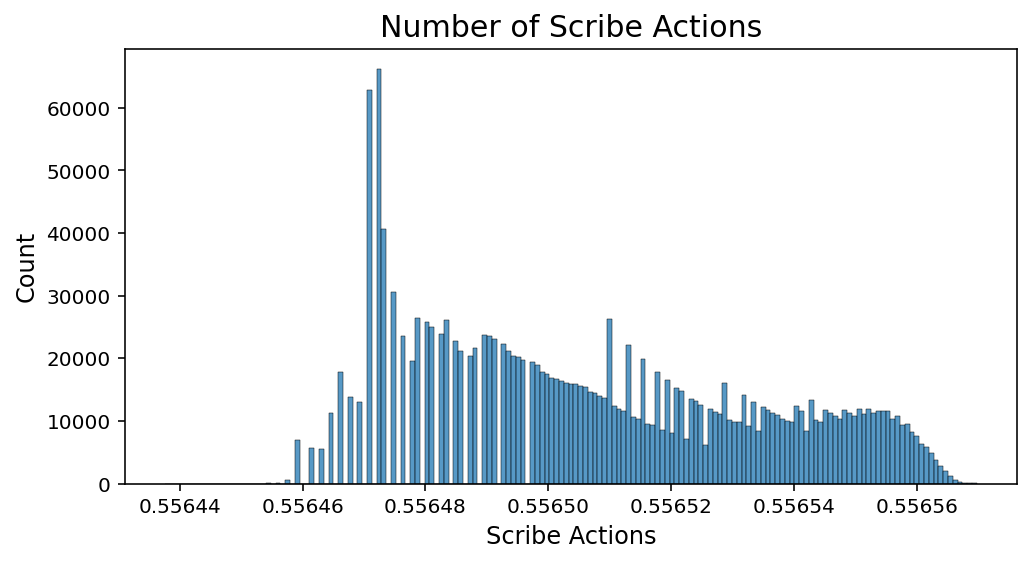

In [ ]:
#histogram plot which shows variable distribution 
plt.figure(figsize=(8,4))
sns.histplot(x='scribe_actions',data=df_optional)
plt.title('Number of Scribe Actions',fontsize=15)
plt.xlabel('Scribe Actions',fontsize=12)
plt.ylabel('Count',fontsize=12)

Text(0, 0.5, 'Count')

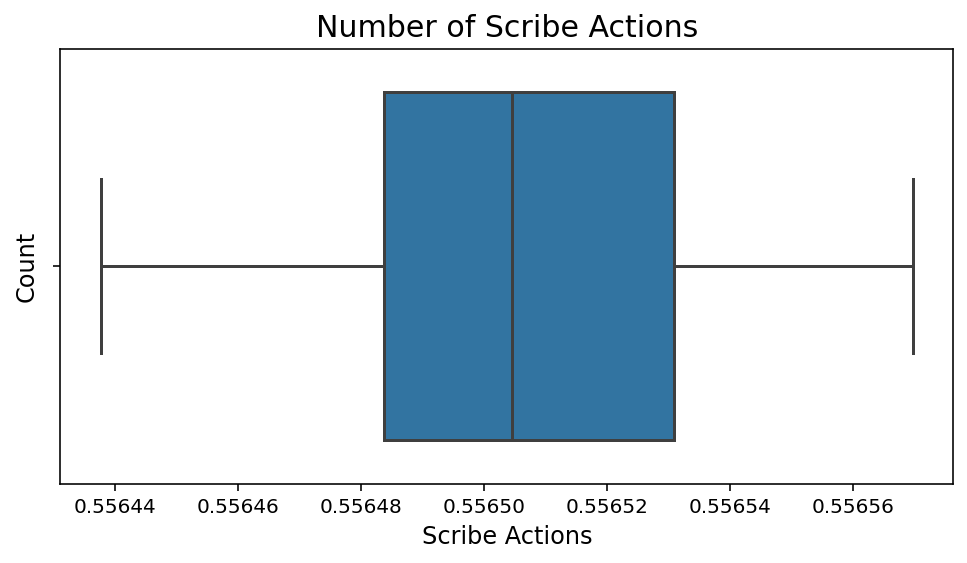

In [ ]:
#boxplot which shows the distribution of a variable
plt.figure(figsize=(8,4))
sns.boxplot(x='scribe_actions',data=df_optional)
plt.title('Number of Scribe Actions',fontsize=15)
plt.xlabel('Scribe Actions',fontsize=12)
plt.ylabel('Count',fontsize=12)

**NOTE:** I studied the performance of Box-Cox on highly skewed data. But it should be noted that one should use Box-Cox to normalize the data after spliting the dataset into train and test sets. 

###**Imbalance Classification**

An imbalanced classification is a classification where the distribution of classes in the training dataset is unequal. Imbalanced dataset results in poor predictive performance of the model for the minority class.
There are some methods to deal with this problem.

1- One of the famouse method is SMOTE (Synthetic Minority Oversampling Technique) where new data is synthesizing from the minority class.

2- Another way is to give different weights to both the majority and minority classes. We penalize the misclassification made by the minority class by setting a higher class weight and at the same time we reduce the weight for the majority class. 

In the following, it can be seen that our data is highly imbalanced. I will study the performance of regular Random Forest classifier, Random Forest classifier with SMOTE and RandomUnderSampler method, and Random Forest classifier with class-wights. To compare these three classifiers, I will consider F1-score since it is a better metric when there are imbalanced classes.

In [ ]:
#Find different categories and their number in the column 
df_final['total_spend'].value_counts()

0    1720913
1      30691
Name: total_spend, dtype: int64

In [ ]:
#dependent and independent variables
X = df_final.loc[:, df_final.columns != 'total_spend'].values
y = df_final.loc[:,'total_spend'].values

In [ ]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

First I will train the model on imbalanced dataset to study the performance of the model. As I mentioned before tree based algorithm such as random forest relies on rules and they don't need normalization. I compared the performance of the classifiers with and without using StandardScaler and the performance didn't change dramatically. It should be noted that in case of using StandarsScaler, the last 12 columns are the result of transforming the categorical variables and they don't need to be scaled as they are normalized.

In [ ]:
#scaling the train dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:,:-12] = sc.fit_transform(X_train[:,:-12])
X_test [:,:-12]= sc.transform(X_test[:,:-12])

In [ ]:
# #scaling the train dataset
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train= sc.fit_transform(X_train)
# X_test= sc.transform(X_test)

1- Regular Random Forest

In [ ]:
#training the model on imbalanced dataset
classifier = RandomForestClassifier(n_estimators = 10,random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Accuracy: 0.98 %
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    344162
           1       0.43      0.01      0.03      6159

    accuracy                           0.98    350321
   macro avg       0.71      0.51      0.51    350321
weighted avg       0.97      0.98      0.97    350321



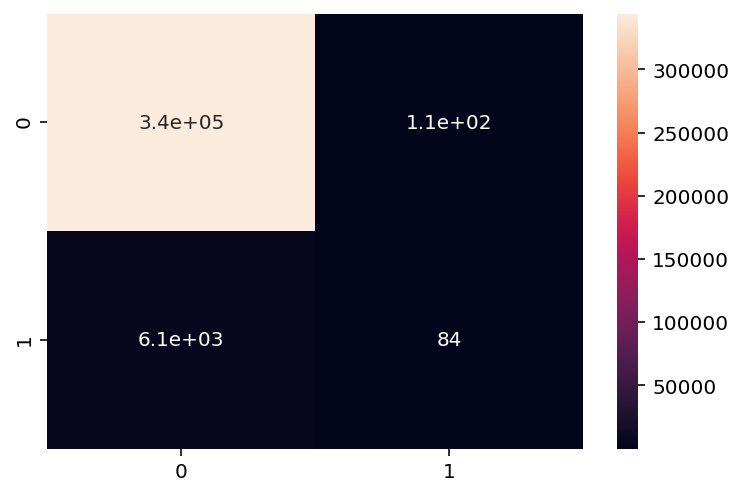

In [ ]:
#make the confusion matrix to study the performance of the model
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

2- SMOTE

Now I use SMOTE method to make the dataset more balanced to improve the performance of the model. It should be noted that I combine SMOTE with RandomUnderSampler as it is suggested in many articles.

In [ ]:
#transform the dataset using SMOTE and RandomUnderSampler method
smt=SMOTE(random_state=0,sampling_strategy=0.1)
rus=RandomUnderSampler(random_state=0,sampling_strategy=0.5)
steps = [('o', smt), ('u', rus)]
pipeline = Pipeline(steps=steps)
X_train_smt,y_train_smt = pipeline.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#training the model on imbalanced dataset
classifier_sm = RandomForestClassifier(n_estimators = 10,random_state = 0)
classifier_sm.fit(X_train_smt, y_train_smt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Accuracy: 0.96 %
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    344162
           1       0.14      0.26      0.18      6159

    accuracy                           0.96    350321
   macro avg       0.56      0.61      0.58    350321
weighted avg       0.97      0.96      0.96    350321



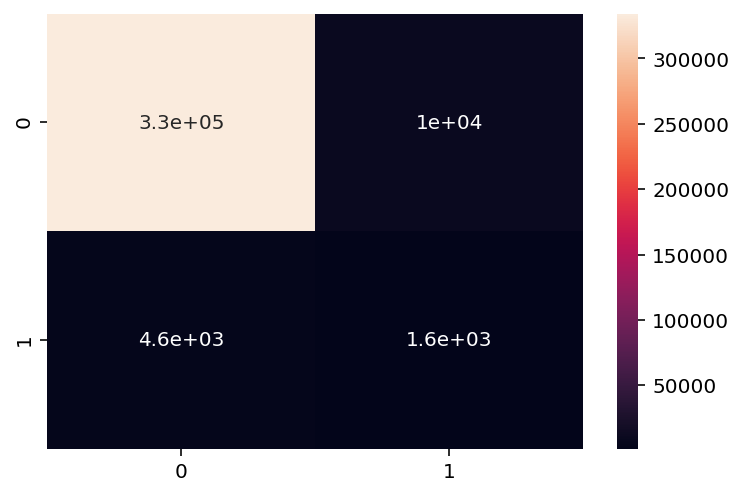

In [ ]:
#make the confusion matrix to study the performance of the model
y_pred = classifier_sm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

3- Random Forest with Class-Weight

The formula to calculate the weight of the classes is:

**wj=n_samples / (n_classes * n_samplesj)**


*   wj is the weight for each class(j signifies the class)

*   n_samplesis the total number of samples or rows in the dataset

*   n_classes is the total number of unique classes in the target

*   n_samplesj is the total number of rows of the respective class

In [ ]:
class_weight={0:1751604/ (2* 1720913),1:1751604/(2*30691)}

In [ ]:
#training the model on imbalanced dataset
classifier_w = RandomForestClassifier(n_estimators = 10,random_state = 0,class_weight=class_weight)
classifier_w.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5089170690209208,
                                     1: 28.536118080218955},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Accuracy: 0.98 %
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    344162
           1       0.28      0.00      0.01      6159

    accuracy                           0.98    350321
   macro avg       0.63      0.50      0.50    350321
weighted avg       0.97      0.98      0.97    350321



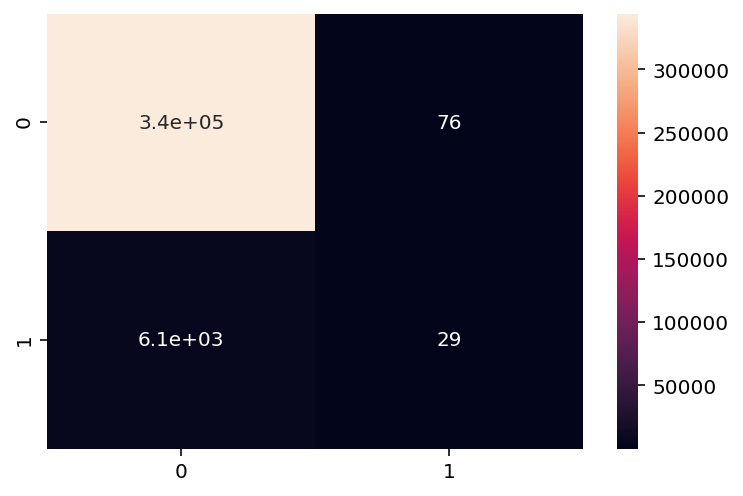

In [ ]:
#make the confusion matrix to study the performance of the model
y_pred = classifier_w.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

So from the results (f1 score results) we can conclud that the performance of the model using SMOTE and RandomUnderSampler is the best.

Next I use k-fold cross validation to study the average performance of the selected model.

In [ ]:
#k-fold cross validation
f1 = cross_val_score(estimator = classifier_sm, X = X_train_smt, y = y_train_smt, scoring='f1',cv = 5)
print("average f1_score: {:.2f} %".format(f1.mean()*100))
print("Standard Deviation: {:.2f} %".format(f1.std()*100))

average f1_score: 85.49 %
Standard Deviation: 15.67 %


In [ ]:
#k-fold cross validation
f1 = cross_val_score(estimator = classifier_sm, X = X_train_smt, y = y_train_smt, scoring='accuracy',cv = 5)
print("mean accuracy: {:.2f} %".format(f1.mean()*100))
print("Standard Deviation: {:.2f} %".format(f1.std()*100))

mean accuracy: 92.10 %
Standard Deviation: 6.84 %


In the following, one can find the probability of users that are likely to spend money after finishing the tutorial. I use the predict_proba function to use the probability. It should be noted that one can select a threshold for the probability to change the class of prediction based on the threshold. 

In [ ]:
#probability of user who are likely to spend in-game
prob=classifier_sm.predict_proba(X_test)[:,1]
prob

array([0. , 0.2, 0. , ..., 0.1, 0.2, 0. ])

In [ ]:
#change the class of prediction based on the threshold
# threshold=0
# preds = [1 if prob[i]> threshold else 0 for i in range(len(prob))]

Now the list and the plot of the features and their importance can be shown as follows. Feature importance gives us important insight into data. The relative scores give us information about features which may be most relevant to the target, and which features are the least relevant. 

In [ ]:
#list of dependent features
features=df_final.loc[:, df_final.columns != 'total_spend'].columns

In [ ]:
#find the feature importance
importance_df = pd.DataFrame({'feature importance':classifier_sm.feature_importances_})
importance_df['features'] = features
importance_df.reset_index(inplace=True, drop=True)
importance_df

,feature importance,features
0,0.037421,local_time_join_dow
1,0.116562,logins
2,0.045714,game_stats_tutorial_complete_time
3,0.077034,game_stats_xp
4,0.097063,game_stats_xp1
5,0.039336,game_stats_xp2
6,0.028194,game_stats_xp3
7,0.093519,redeemer_actions
8,0.158491,scribe_actions
9,0.063453,device_mem_grouping_i


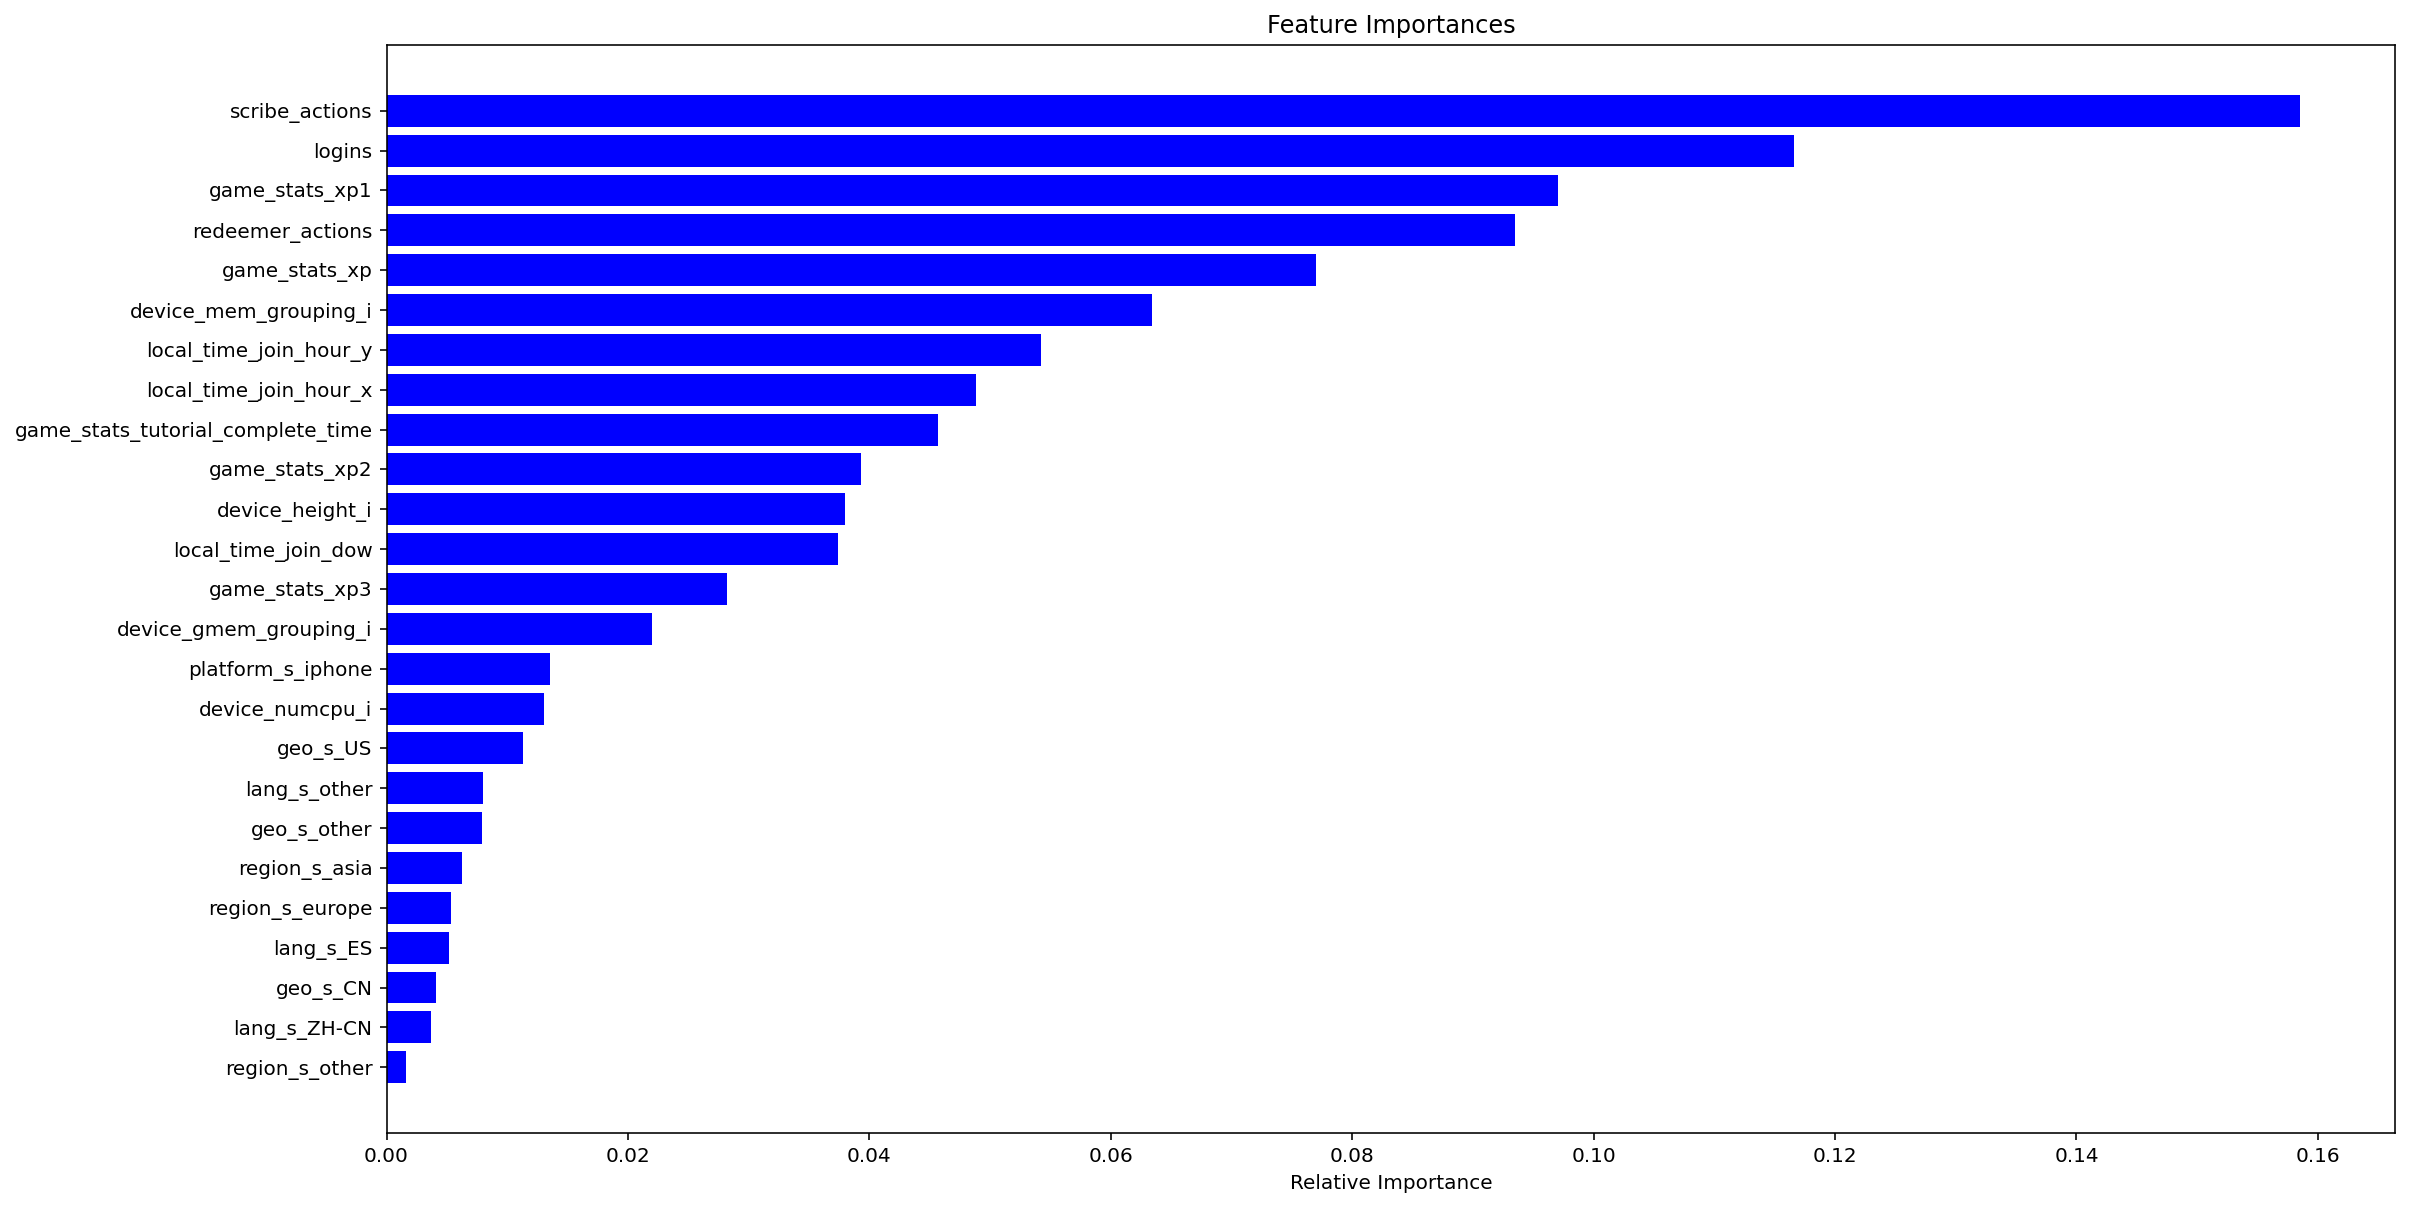

In [ ]:
#plot the feature importance
feat_importances = pd.Series(classifier_sm.feature_importances_, index=features)
indices = np.argsort(feat_importances)
f, ax = plt.subplots(figsize=(18,10))

plt.title('Feature Importances')
plt.barh(range(len(indices)), feat_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

According to Random Forest classifier feature_importances_  'scribe_actions', 'game_stats_xp', number of 'logins' are the 3 top important indicators to predict the users who are likely to spend in-game.

In addition, one can use Gridsearch method to find the best hyperparameters for the model. As we have a very big dataset, this process was slow on my laptop.

In [ ]:
# #set the hyperparameters 
# parameters = { 
#     'n_estimators': [10, 20],
#     'criterion' :['gini', 'entropy'],
#     'class_weight':['balanced']
# }

# #define the classifier
# classifier = RandomForestClassifier(random_state = 0)

# # use grid search to find the best hyper parameters and the best score
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(estimator = classifier,
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 5,
#                            n_jobs = -1) #scoring='f1' can be used too.
# grid_search.fit(X_train, y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_
# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters:", best_parameters)


**Conclusion:**

1) From the Random Forest classifier feature importance plot, we can conclude that 'scribe_actions', 'game_stats_xp', number of 'logins' are the 3 top important indicators to predict the users who are likely to spend in-game while region and language of the device are less important. 

2) Larger proportion of users who are using devices with Chinese language are more likely to spend in-game.

3) A larger proportion of users in US category are likely to spend in-game after finishing the tutorial.

4) A larger proportion of the ones who have iPhone are more likely to spend in-game after tutorial.

5) A larger proportion of people who joind at 2:00 am and a larger proportion of users who join at days 6 and day 2 are likely to spend in-game, but the differences are not large.

6) 6 CPU cores are more likely to spend in-game. On the other hand, users with 4 CPU cores are less likely to spend in-game compared to the other four most common CPU core counts. In addition, users with devices that have GPU memory of 4096 MB are much more likely to spend in-game, followed by users with 2048 MB of GPU memory.

7) Highest proportion of users with device height size of 750 are more likely to spend in-game.

8- Users who accumulated more experience points by first time interval from install are more likely to spend in-game.